# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import datetime
import pickle
# Files imported from the sleected GitHub https://cka-similarity.github.io/
from CKA_Google import *
import seaborn as sns 
import random
import matplotlib.pyplot as plt 

C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Experiment 1 : Understand Network Architecture

## Configure the hyperparameters

In [2]:
weight_decay = 0.0001
batch_size = 512 
num_epochs = 50
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 224  # We'll resize input images to this size. Square
patch_size = 32  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = [384]  # Fixed Embedding Dimension
num_blocks = [8,12,24,32]

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

#now = datetime.datetime.now()
#date = now.strftime("%Y-%m-%d_%H-%M")
now = datetime.datetime.today()
date = now.strftime("%Y-%m-%d")


Image size: 224 X 224 = 50176
Patch size: 32 X 32 = 1024 
Patches per image: 49
Elements per patch (3 channels): 3072


In [3]:
now = datetime.datetime.today()
date = now.strftime("%Y-%m-%d")
str(date)

'2022-02-25'

## Prepare the data

In [4]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Build a classification model

In [5]:
def build_classifier(blocks, embedding_dim, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

In [6]:
def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history, accuracy, top_5_accuracy

## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer

In [8]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config().copy()
        config.update ({
            'patch_size' : self.patch_size ,
            'num_patches' : self.num_patches
        })
        return config

## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [9]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

    def get_config(self): 
        config = super(MLPMixerLayer, self).get_config().copy()
        config.update ({
            'num_patches' : num_patches,
            'embedding_dim' : embedding_dim,
            'dropout_rate' : dropout_rate,
        })
        return config

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [10]:
# Report: Learning Curve
def curves(history):
    ymax1 = min(history["loss"])
    xmax1 = history["loss"].index(ymax1)
    ymax2 = min(history["val_loss"])
    xmax2 = history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(history["loss"], color = 'blue', label = 'Training')
    plt.plot(history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history["acc"])
    xmax3 = history["acc"].index(ymax3)
    ymax4 = max(history["val_acc"])
    xmax4 = history["val_acc"].index(ymax4)
    ymax5 = max(history["top5-acc"])
    xmax5 = history["top5-acc"].index(ymax5)
    ymax6 = max(history["val_top5-acc"])
    xmax6 = history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(history['acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Obtain activations + Visualization

In [11]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [12]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [13]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [14]:
def Mixer_Layer_Outputs(model_input, model_output,example):
    #The input is fixed to the beginning of the mlp blocks
    intermediate_model=tf.keras.models.Model(inputs=model_input.input,outputs=model_output.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [15]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(model, example):
    total_activations = list()
    for i in range(num_blocks):
        model_input = model.layers[4].layers[0]
        model_output = model.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_input, model_output, example)
        total_activations.append(int_total_activations)
    return  total_activations

In [16]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(model,batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(model,batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

# CKA

In [17]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type,sigma):
    dim = len(result)
    k = (dim - 1)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        tr = (dim - 1)
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[k][tr] = cka(gram_rbf(result[i],sigma),gram_rbf(result[j],sigma))
            elif type == 'linear':
                heatmap_CKA[k][tr] = cka(gram_linear(result[i]),gram_linear(result[j])) 
            else:
                print('There is no such category, try again')
                break

            tr -= 1
        k -= 1
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [18]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps

In [19]:
def visualize_Heatmap(heatmap,type,bl):
    #Number of thats that you want to appear in the plot
    tri = 4
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _, ax = plt.subplots(figsize=(6,6))
        ax = sns.heatmap(heatmap, xticklabels=axis_labels[::-1], yticklabels=axis_labels[::-1], ax = ax, annot=bl)
        #sns.heatmap(heatmap, xticklabels=2, yticklabels=2, ax = ax, annot=bl, cbar=True)   
        ax.invert_xaxis()
        ax.axhline(y = 0, color='k',linewidth = 4)
        ax.axhline(y = heatmap.shape[1], color = 'k', linewidth = 4)
        ax.axvline(x = 0, color ='k',linewidth = 4)
        ax.axvline(x = heatmap.shape[0], color = 'k', linewidth = 4)

        ax.set_title("CKA-"+ type)   
        ax.set_xlabel("Layer")
        ax.set_ylabel("Layer")
        plt.yticks(rotation=0)
        plt.locator_params(axis='x',nbins=tri)
        plt.locator_params(axis='y',nbins=tri)
        plt.savefig('CKA_'+ type +'.png', dpi=300)
        
    else:
        print('There is no such category, try again')

# Experiment 1 : Understand Network Architecture

## 1A: Different Depths

In [20]:
#Create different mlpmixers according to an array of widths or depths
def mlpmixer_iterations(num_patches,experiment,embedding_dim,num_blocks):
    it_widths = len(embedding_dim)
    it_blocks = len(num_blocks)
    for j in range(it_widths):
        for i in range(it_blocks):
            mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim[j], dropout_rate) for _ in range(num_blocks[i])] # creates the number of block without a 
            )
            mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim[j]) # Returns the model
            history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
            #Saving Results
            pwd = 'Results_Article/'+ str(experiment) +'/mlpmixer_'+ str(num_blocks[i]) + 'ly_' + str(embedding_dim[j]) + 'Dc_' + str(date)
            mlpmixer_classifier.save(pwd)
            np.save( pwd + '/history_' + str(date) +'.npy',history.history)
            with open(pwd + '/accuracy.pkl','wb') as file:
                pickle.dump(accuracy,file)
            with open(pwd + '/top5-accuracy.pkl','wb') as file:
                pickle.dump(top_5_accuracy,file)

In [21]:
mlpmixer_iterations(num_patches,'1A', embedding_dim,num_blocks)

Epoch 1/50
88/88 [==============================] - 23s 175ms/step - loss: 4.3321 - acc: 0.2489 - top5-acc: 0.7386 - val_loss: 1.7087 - val_acc: 0.4014 - val_top5-acc: 0.8784 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 15s 165ms/step - loss: 1.6032 - acc: 0.4166 - top5-acc: 0.8958 - val_loss: 1.4820 - val_acc: 0.4730 - val_top5-acc: 0.9206 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 15s 171ms/step - loss: 1.4428 - acc: 0.4808 - top5-acc: 0.9226 - val_loss: 1.3782 - val_acc: 0.5148 - val_top5-acc: 0.9348 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 15s 165ms/step - loss: 1.3734 - acc: 0.5052 - top5-acc: 0.9317 - val_loss: 1.2743 - val_acc: 0.5458 - val_top5-acc: 0.9462 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 15s 171ms/step - loss: 1.3235 - acc: 0.5250 - top5-acc: 0.9398 - val_loss: 1.2422 - val_acc: 0.5602 - val_top5-acc: 0.9478 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 15s 165m

88/88 [==============================] - 15s 172ms/step - loss: 0.7118 - acc: 0.7473 - top5-acc: 0.9842 - val_loss: 0.7358 - val_acc: 0.7520 - val_top5-acc: 0.9860 - lr: 0.0025
Epoch 45/50
88/88 [==============================] - 15s 167ms/step - loss: 0.7047 - acc: 0.7531 - top5-acc: 0.9858 - val_loss: 0.7475 - val_acc: 0.7454 - val_top5-acc: 0.9860 - lr: 0.0025
Epoch 46/50
88/88 [==============================] - 15s 166ms/step - loss: 0.7014 - acc: 0.7525 - top5-acc: 0.9863 - val_loss: 0.7551 - val_acc: 0.7436 - val_top5-acc: 0.9850 - lr: 0.0025
Epoch 47/50
88/88 [==============================] - 14s 164ms/step - loss: 0.7048 - acc: 0.7512 - top5-acc: 0.9851 - val_loss: 0.7426 - val_acc: 0.7476 - val_top5-acc: 0.9846 - lr: 0.0025
Epoch 48/50
88/88 [==============================] - 14s 165ms/step - loss: 0.7015 - acc: 0.7525 - top5-acc: 0.9853 - val_loss: 0.7501 - val_acc: 0.7498 - val_top5-acc: 0.9844 - lr: 0.0025
Epoch 49/50
88/88 [==============================] - 15s 165ms/step

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_8ly_384Dc_2022-02-25\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_8ly_384Dc_2022-02-25\assets


Epoch 1/50
88/88 [==============================] - 32s 254ms/step - loss: 4.2115 - acc: 0.2483 - top5-acc: 0.7391 - val_loss: 1.6315 - val_acc: 0.4080 - val_top5-acc: 0.8942 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 21s 237ms/step - loss: 1.5697 - acc: 0.4326 - top5-acc: 0.9042 - val_loss: 1.5161 - val_acc: 0.4570 - val_top5-acc: 0.9186 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 21s 239ms/step - loss: 1.4421 - acc: 0.4758 - top5-acc: 0.9249 - val_loss: 1.3638 - val_acc: 0.5112 - val_top5-acc: 0.9336 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 21s 238ms/step - loss: 1.3532 - acc: 0.5129 - top5-acc: 0.9350 - val_loss: 1.2329 - val_acc: 0.5586 - val_top5-acc: 0.9498 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 21s 241ms/step - loss: 1.2826 - acc: 0.5390 - top5-acc: 0.9449 - val_loss: 1.1940 - val_acc: 0.5772 - val_top5-acc: 0.9540 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 21s 237m

88/88 [==============================] - 21s 234ms/step - loss: 0.5812 - acc: 0.7941 - top5-acc: 0.9909 - val_loss: 0.7059 - val_acc: 0.7688 - val_top5-acc: 0.9840 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 21s 233ms/step - loss: 0.5803 - acc: 0.7937 - top5-acc: 0.9911 - val_loss: 0.7201 - val_acc: 0.7650 - val_top5-acc: 0.9842 - lr: 0.0012
Epoch 46/50
88/88 [==============================] - 20s 233ms/step - loss: 0.5729 - acc: 0.7980 - top5-acc: 0.9909 - val_loss: 0.7063 - val_acc: 0.7670 - val_top5-acc: 0.9838 - lr: 0.0012
Epoch 47/50
88/88 [==============================] - 21s 234ms/step - loss: 0.5688 - acc: 0.7978 - top5-acc: 0.9905 - val_loss: 0.7020 - val_acc: 0.7656 - val_top5-acc: 0.9830 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 20s 233ms/step - loss: 0.5652 - acc: 0.7996 - top5-acc: 0.9910 - val_loss: 0.7358 - val_acc: 0.7608 - val_top5-acc: 0.9846 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 21s 233ms/step

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_12ly_384Dc_2022-02-25\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_12ly_384Dc_2022-02-25\assets


Epoch 1/50
88/88 [==============================] - 58s 475ms/step - loss: 3.7094 - acc: 0.2587 - top5-acc: 0.7468 - val_loss: 1.5772 - val_acc: 0.4268 - val_top5-acc: 0.9046 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 39s 448ms/step - loss: 1.5435 - acc: 0.4450 - top5-acc: 0.9075 - val_loss: 1.3661 - val_acc: 0.5034 - val_top5-acc: 0.9354 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 39s 449ms/step - loss: 1.3851 - acc: 0.5023 - top5-acc: 0.9305 - val_loss: 1.3228 - val_acc: 0.5278 - val_top5-acc: 0.9388 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 40s 450ms/step - loss: 1.3150 - acc: 0.5280 - top5-acc: 0.9396 - val_loss: 1.1890 - val_acc: 0.5802 - val_top5-acc: 0.9532 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 40s 450ms/step - loss: 1.2518 - acc: 0.5528 - top5-acc: 0.9456 - val_loss: 1.1533 - val_acc: 0.5834 - val_top5-acc: 0.9580 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 40s 450m

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_24ly_384Dc_2022-02-25\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_24ly_384Dc_2022-02-25\assets


Epoch 1/50
88/88 [==============================] - 77s 623ms/step - loss: 3.8658 - acc: 0.2573 - top5-acc: 0.7438 - val_loss: 1.5958 - val_acc: 0.4350 - val_top5-acc: 0.8968 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 52s 587ms/step - loss: 1.5590 - acc: 0.4394 - top5-acc: 0.9026 - val_loss: 1.3641 - val_acc: 0.5030 - val_top5-acc: 0.9312 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 52s 589ms/step - loss: 1.3921 - acc: 0.5006 - top5-acc: 0.9290 - val_loss: 1.2654 - val_acc: 0.5468 - val_top5-acc: 0.9506 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 52s 589ms/step - loss: 1.3031 - acc: 0.5354 - top5-acc: 0.9398 - val_loss: 1.1514 - val_acc: 0.5882 - val_top5-acc: 0.9562 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 52s 587ms/step - loss: 1.2457 - acc: 0.5571 - top5-acc: 0.9464 - val_loss: 1.1569 - val_acc: 0.5798 - val_top5-acc: 0.9578 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 52s 586m

88/88 [==============================] - 52s 589ms/step - loss: 0.6500 - acc: 0.7732 - top5-acc: 0.9880 - val_loss: 0.7537 - val_acc: 0.7502 - val_top5-acc: 0.9852 - lr: 0.0025
Epoch 45/50
88/88 [==============================] - 52s 587ms/step - loss: 0.6500 - acc: 0.7684 - top5-acc: 0.9880 - val_loss: 0.7672 - val_acc: 0.7408 - val_top5-acc: 0.9818 - lr: 0.0025
Epoch 46/50
88/88 [==============================] - 52s 588ms/step - loss: 0.6340 - acc: 0.7770 - top5-acc: 0.9891 - val_loss: 0.7976 - val_acc: 0.7350 - val_top5-acc: 0.9822 - lr: 0.0025
Epoch 47/50
88/88 [==============================] - 52s 587ms/step - loss: 0.6333 - acc: 0.7763 - top5-acc: 0.9890 - val_loss: 0.7747 - val_acc: 0.7388 - val_top5-acc: 0.9844 - lr: 0.0025
Epoch 48/50
88/88 [==============================] - 52s 589ms/step - loss: 0.6339 - acc: 0.7742 - top5-acc: 0.9890 - val_loss: 0.7519 - val_acc: 0.7438 - val_top5-acc: 0.9834 - lr: 0.0025
Epoch 49/50
88/88 [==============================] - 52s 588ms/step

INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_32ly_384Dc_2022-02-25\assets


INFO:tensorflow:Assets written to: Results_Article/1A/mlpmixer_32ly_384Dc_2022-02-25\assets


# 1B

## Configure the hyperparameters

In [22]:
# This is the only parameter that have to be initialized since, all the parameters are shared with Experiment 1A
embedding_d = embedding_dim[0]  # Fixed Embedding Dimension from experiment 1A
path_1B = 'Results_Article/1B'

In [23]:
def evol_accuracy(all_models,num_blocks):
    total_plots=list()
    for f in range(len(all_models)) :
        testing_model = all_models[f]
        partial_plots = list()
        for j in range(num_blocks[f]):
            #Define the Mixer Block that are going to participate (Cumulative Approach)
            inter_input = testing_model.layers[4].layers[0].input
            inter_output = testing_model.layers[4].layers[j].output
            partial_models=tf.keras.models.Model(inputs=inter_input,outputs=inter_output, name = 'Mixer_Blocks')
            #Create the structure of the model
            inputs = layers.Input(shape=input_shape)
            augmented = data_augmentation(inputs)
            patches = Patches(patch_size, num_patches)(augmented)
            x = testing_model.layers[3](patches)
            intermediate_output  =  partial_models(x)
            representation = layers.GlobalAveragePooling1D()(intermediate_output)
            output =  layers.Dense(units=num_classes, activation='softmax')(representation) # Linear regression that is going to be trained
            final_modelx =   keras.Model(inputs=inputs, outputs=output)
            #Set the condition to not trainable
            final_modelx.layers[3].trainable = False
            final_modelx.layers[4].trainable = False
            __,accuracy,__= run_experiment(final_modelx)
            with open(path_1B + '/accuracy_Blocks_'+ str(num_blocks[f]) + '_L' + str(j+1)+ '.pkl','wb') as file:
                        pickle.dump(accuracy,file)
            partial_plots.append(accuracy)
        total_plots.append(partial_plots)
    return total_plots

Change the path in this cell (loading results from the experiment 1A)

In [24]:
num_blocks

[8, 12, 24, 32]

In [25]:
all_models = list()
for layer in num_blocks:
    #Call the folder
    pwd1 = 'Results_Article/1A/mlpmixer_'+ str(layer) + 'ly_' + str(embedding_d) + 'Dc_' + str(date) 
    layers_models = tf.keras.models.load_model(pwd1, compile=False)
    all_models.append(layers_models)       

In [26]:
tested_acc_evolution = evol_accuracy(all_models,num_blocks)

Epoch 1/50


C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 3s 26ms/step - loss: 2.4545 - acc: 0.3160 - top5-acc: 0.8303 - val_loss: 1.7603 - val_acc: 0.3774 - val_top5-acc: 0.8824 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 2s 24ms/step - loss: 1.8285 - acc: 0.3701 - top5-acc: 0.8739 - val_loss: 1.6940 - val_acc: 0.4036 - val_top5-acc: 0.8922 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 2s 24ms/step - loss: 1.8088 - acc: 0.3774 - top5-acc: 0.8772 - val_loss: 1.7759 - val_acc: 0.4044 - val_top5-acc: 0.8904 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7696 - acc: 0.3898 - top5-acc: 0.8818 - val_loss: 1.6449 - val_acc: 0.4174 - val_top5-acc: 0.9002 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7602 - acc: 0.3930 - top5-acc: 0.8814 - val_loss: 1.5855 - val_acc: 0.4358 - val_top5-acc: 0.9100 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7458 -

Epoch 45/50
88/88 [==============================] - 2s 24ms/step - loss: 1.5177 - acc: 0.4610 - top5-acc: 0.9100 - val_loss: 1.4646 - val_acc: 0.4746 - val_top5-acc: 0.9192 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 2s 24ms/step - loss: 1.5143 - acc: 0.4616 - top5-acc: 0.9118 - val_loss: 1.4664 - val_acc: 0.4762 - val_top5-acc: 0.9208 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 2s 24ms/step - loss: 1.5173 - acc: 0.4621 - top5-acc: 0.9097 - val_loss: 1.4717 - val_acc: 0.4704 - val_top5-acc: 0.9212 - lr: 3.1250e-04
Epoch 48/50
88/88 [==============================] - 2s 24ms/step - loss: 1.5127 - acc: 0.4642 - top5-acc: 0.9095 - val_loss: 1.4669 - val_acc: 0.4734 - val_top5-acc: 0.9196 - lr: 1.5625e-04
Epoch 49/50
88/88 [==============================] - 2s 24ms/step - loss: 1.5118 - acc: 0.4624 - top5-acc: 0.9107 - val_loss: 1.4562 - val_acc: 0.4770 - val_top5-acc: 0.9204 - lr: 1.5625e-04
Epoch 50/50
313/313 [========================

Epoch 38/50
88/88 [==============================] - 3s 32ms/step - loss: 1.3886 - acc: 0.5070 - top5-acc: 0.9300 - val_loss: 1.2991 - val_acc: 0.5426 - val_top5-acc: 0.9362 - lr: 6.2500e-04
Epoch 39/50
88/88 [==============================] - 3s 33ms/step - loss: 1.3898 - acc: 0.5069 - top5-acc: 0.9303 - val_loss: 1.2997 - val_acc: 0.5414 - val_top5-acc: 0.9410 - lr: 6.2500e-04
Epoch 40/50
88/88 [==============================] - 3s 32ms/step - loss: 1.3891 - acc: 0.5074 - top5-acc: 0.9296 - val_loss: 1.3058 - val_acc: 0.5402 - val_top5-acc: 0.9368 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] - 3s 32ms/step - loss: 1.3896 - acc: 0.5092 - top5-acc: 0.9300 - val_loss: 1.2924 - val_acc: 0.5440 - val_top5-acc: 0.9376 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 3s 32ms/step - loss: 1.3942 - acc: 0.5077 - top5-acc: 0.9279 - val_loss: 1.3057 - val_acc: 0.5398 - val_top5-acc: 0.9364 - lr: 6.2500e-04
Epoch 43/50
88/88 [==========================

Epoch 5/50
88/88 [==============================] - 4s 49ms/step - loss: 1.4217 - acc: 0.5047 - top5-acc: 0.9290 - val_loss: 1.3415 - val_acc: 0.5418 - val_top5-acc: 0.9330 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 4s 49ms/step - loss: 1.4041 - acc: 0.5130 - top5-acc: 0.9302 - val_loss: 1.3091 - val_acc: 0.5464 - val_top5-acc: 0.9450 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4206 - acc: 0.5066 - top5-acc: 0.9285 - val_loss: 1.3185 - val_acc: 0.5398 - val_top5-acc: 0.9408 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 4s 49ms/step - loss: 1.4005 - acc: 0.5128 - top5-acc: 0.9314 - val_loss: 1.2901 - val_acc: 0.5532 - val_top5-acc: 0.9458 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 4s 49ms/step - loss: 1.3885 - acc: 0.5158 - top5-acc: 0.9334 - val_loss: 1.2988 - val_acc: 0.5522 - val_top5-acc: 0.9426 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 4s 49ms/step - lo

88/88 [==============================] - 4s 48ms/step - loss: 1.2725 - acc: 0.5561 - top5-acc: 0.9428 - val_loss: 1.1765 - val_acc: 0.5880 - val_top5-acc: 0.9526 - lr: 1.5625e-04
Epoch 49/50
88/88 [==============================] - 4s 49ms/step - loss: 1.2719 - acc: 0.5550 - top5-acc: 0.9433 - val_loss: 1.1764 - val_acc: 0.5850 - val_top5-acc: 0.9532 - lr: 1.5625e-04
Epoch 50/50
313/313 [==============================] - 5s 16ms/step - loss: 1.2247 - acc: 0.5725 - top5-acc: 0.9492
Test accuracy: 57.25%
Test top 5 accuracy: 94.92%
Epoch 1/50
88/88 [==============================] - 7s 62ms/step - loss: 1.8961 - acc: 0.4017 - top5-acc: 0.8760 - val_loss: 1.3344 - val_acc: 0.5376 - val_top5-acc: 0.9408 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 5s 57ms/step - loss: 1.4411 - acc: 0.4979 - top5-acc: 0.9268 - val_loss: 1.3253 - val_acc: 0.5282 - val_top5-acc: 0.9426 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 5s 57ms/step - loss: 1.3746 - acc: 0.521

Epoch 41/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2002 - acc: 0.5802 - top5-acc: 0.9514 - val_loss: 1.1139 - val_acc: 0.6042 - val_top5-acc: 0.9592 - lr: 3.1250e-04
Epoch 42/50
88/88 [==============================] - 5s 57ms/step - loss: 1.1948 - acc: 0.5801 - top5-acc: 0.9514 - val_loss: 1.1134 - val_acc: 0.6016 - val_top5-acc: 0.9604 - lr: 3.1250e-04
Epoch 43/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2008 - acc: 0.5769 - top5-acc: 0.9501 - val_loss: 1.1175 - val_acc: 0.6044 - val_top5-acc: 0.9604 - lr: 3.1250e-04
Epoch 44/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2022 - acc: 0.5795 - top5-acc: 0.9515 - val_loss: 1.1121 - val_acc: 0.6106 - val_top5-acc: 0.9606 - lr: 3.1250e-04
Epoch 45/50
88/88 [==============================] - 5s 57ms/step - loss: 1.1993 - acc: 0.5783 - top5-acc: 0.9515 - val_loss: 1.1061 - val_acc: 0.6112 - val_top5-acc: 0.9608 - lr: 3.1250e-04
Epoch 46/50
88/88 [==========================

Epoch 34/50
88/88 [==============================] - 6s 65ms/step - loss: 1.1542 - acc: 0.5963 - top5-acc: 0.9550 - val_loss: 1.0403 - val_acc: 0.6388 - val_top5-acc: 0.9638 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 6s 64ms/step - loss: 1.1542 - acc: 0.5971 - top5-acc: 0.9528 - val_loss: 1.0602 - val_acc: 0.6322 - val_top5-acc: 0.9644 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 6s 64ms/step - loss: 1.1519 - acc: 0.5967 - top5-acc: 0.9536 - val_loss: 1.0393 - val_acc: 0.6374 - val_top5-acc: 0.9644 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 6s 65ms/step - loss: 1.1518 - acc: 0.5929 - top5-acc: 0.9554 - val_loss: 1.0368 - val_acc: 0.6396 - val_top5-acc: 0.9650 - lr: 0.0012
Epoch 38/50
88/88 [==============================] - 6s 64ms/step - loss: 1.1530 - acc: 0.5967 - top5-acc: 0.9536 - val_loss: 1.0532 - val_acc: 0.6332 - val_top5-acc: 0.9642 - lr: 6.2500e-04
Epoch 39/50
88/88 [==============================] - 6s 64ms/

Epoch 35/50
88/88 [==============================] - 6s 73ms/step - loss: 0.9026 - acc: 0.6847 - top5-acc: 0.9726 - val_loss: 0.8716 - val_acc: 0.7028 - val_top5-acc: 0.9758 - lr: 6.2500e-04
Epoch 36/50
88/88 [==============================] - 6s 73ms/step - loss: 0.9071 - acc: 0.6852 - top5-acc: 0.9731 - val_loss: 0.8739 - val_acc: 0.7052 - val_top5-acc: 0.9772 - lr: 6.2500e-04
Epoch 37/50
88/88 [==============================] - 6s 72ms/step - loss: 0.9033 - acc: 0.6834 - top5-acc: 0.9728 - val_loss: 0.8735 - val_acc: 0.7020 - val_top5-acc: 0.9754 - lr: 6.2500e-04
Epoch 38/50
88/88 [==============================] - 6s 73ms/step - loss: 0.9057 - acc: 0.6828 - top5-acc: 0.9733 - val_loss: 0.8710 - val_acc: 0.7032 - val_top5-acc: 0.9758 - lr: 6.2500e-04
Epoch 39/50
88/88 [==============================] - 6s 73ms/step - loss: 0.9065 - acc: 0.6833 - top5-acc: 0.9730 - val_loss: 0.8737 - val_acc: 0.7016 - val_top5-acc: 0.9764 - lr: 6.2500e-04
Epoch 40/50
88/88 [==========================

Epoch 28/50
88/88 [==============================] - 7s 81ms/step - loss: 0.5473 - acc: 0.8047 - top5-acc: 0.9923 - val_loss: 0.7312 - val_acc: 0.7652 - val_top5-acc: 0.9866 - lr: 0.0012
Epoch 29/50
88/88 [==============================] - 7s 81ms/step - loss: 0.5481 - acc: 0.8061 - top5-acc: 0.9917 - val_loss: 0.7291 - val_acc: 0.7650 - val_top5-acc: 0.9864 - lr: 0.0012
Epoch 30/50
88/88 [==============================] - 7s 81ms/step - loss: 0.5491 - acc: 0.8062 - top5-acc: 0.9918 - val_loss: 0.7243 - val_acc: 0.7664 - val_top5-acc: 0.9860 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 7s 80ms/step - loss: 0.5531 - acc: 0.8033 - top5-acc: 0.9913 - val_loss: 0.7278 - val_acc: 0.7656 - val_top5-acc: 0.9868 - lr: 0.0012
Epoch 32/50
88/88 [==============================] - 7s 81ms/step - loss: 0.5529 - acc: 0.8032 - top5-acc: 0.9916 - val_loss: 0.7268 - val_acc: 0.7642 - val_top5-acc: 0.9862 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 7s 80ms/step

Epoch 21/50
88/88 [==============================] - 2s 24ms/step - loss: 1.6319 - acc: 0.4129 - top5-acc: 0.8909 - val_loss: 1.5713 - val_acc: 0.4312 - val_top5-acc: 0.9022 - lr: 0.0012
Epoch 22/50
88/88 [==============================] - 2s 24ms/step - loss: 1.6306 - acc: 0.4123 - top5-acc: 0.8921 - val_loss: 1.5775 - val_acc: 0.4276 - val_top5-acc: 0.9008 - lr: 0.0012
Epoch 23/50
88/88 [==============================] - 2s 24ms/step - loss: 1.6155 - acc: 0.4177 - top5-acc: 0.8928 - val_loss: 1.5724 - val_acc: 0.4358 - val_top5-acc: 0.9002 - lr: 6.2500e-04
Epoch 24/50
88/88 [==============================] - 2s 24ms/step - loss: 1.6112 - acc: 0.4231 - top5-acc: 0.8937 - val_loss: 1.5557 - val_acc: 0.4454 - val_top5-acc: 0.9028 - lr: 6.2500e-04
Epoch 25/50
88/88 [==============================] - 2s 24ms/step - loss: 1.6105 - acc: 0.4198 - top5-acc: 0.8948 - val_loss: 1.5612 - val_acc: 0.4400 - val_top5-acc: 0.9046 - lr: 6.2500e-04
Epoch 26/50
88/88 [==============================] - 

88/88 [==============================] - 3s 32ms/step - loss: 1.5521 - acc: 0.4435 - top5-acc: 0.9101 - val_loss: 1.4637 - val_acc: 0.4736 - val_top5-acc: 0.9210 - lr: 0.0025
Epoch 14/50
88/88 [==============================] - 3s 32ms/step - loss: 1.5592 - acc: 0.4426 - top5-acc: 0.9116 - val_loss: 1.4909 - val_acc: 0.4578 - val_top5-acc: 0.9184 - lr: 0.0025
Epoch 15/50
88/88 [==============================] - 3s 33ms/step - loss: 1.5535 - acc: 0.4431 - top5-acc: 0.9095 - val_loss: 1.4629 - val_acc: 0.4722 - val_top5-acc: 0.9234 - lr: 0.0025
Epoch 16/50
88/88 [==============================] - 3s 32ms/step - loss: 1.5406 - acc: 0.4481 - top5-acc: 0.9114 - val_loss: 1.4676 - val_acc: 0.4640 - val_top5-acc: 0.9192 - lr: 0.0025
Epoch 17/50
88/88 [==============================] - 3s 32ms/step - loss: 1.5357 - acc: 0.4490 - top5-acc: 0.9106 - val_loss: 1.4621 - val_acc: 0.4762 - val_top5-acc: 0.9180 - lr: 0.0025
Epoch 18/50
88/88 [==============================] - 3s 32ms/step - loss: 1.5

Epoch 6/50
88/88 [==============================] - 4s 40ms/step - loss: 1.5647 - acc: 0.4501 - top5-acc: 0.9108 - val_loss: 1.4557 - val_acc: 0.4806 - val_top5-acc: 0.9220 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 4s 40ms/step - loss: 1.5678 - acc: 0.4493 - top5-acc: 0.9128 - val_loss: 1.4414 - val_acc: 0.4928 - val_top5-acc: 0.9250 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 4s 40ms/step - loss: 1.5369 - acc: 0.4613 - top5-acc: 0.9132 - val_loss: 1.4681 - val_acc: 0.4946 - val_top5-acc: 0.9200 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 4s 40ms/step - loss: 1.5392 - acc: 0.4577 - top5-acc: 0.9148 - val_loss: 1.5052 - val_acc: 0.4666 - val_top5-acc: 0.9280 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 4s 40ms/step - loss: 1.5367 - acc: 0.4612 - top5-acc: 0.9148 - val_loss: 1.3738 - val_acc: 0.5056 - val_top5-acc: 0.9324 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 4s 40ms/step - l

Epoch 2/50
88/88 [==============================] - 4s 48ms/step - loss: 1.5768 - acc: 0.4441 - top5-acc: 0.9084 - val_loss: 1.4581 - val_acc: 0.4822 - val_top5-acc: 0.9232 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 4s 48ms/step - loss: 1.5214 - acc: 0.4676 - top5-acc: 0.9147 - val_loss: 1.3819 - val_acc: 0.5040 - val_top5-acc: 0.9292 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4930 - acc: 0.4783 - top5-acc: 0.9164 - val_loss: 1.3585 - val_acc: 0.5196 - val_top5-acc: 0.9368 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4698 - acc: 0.4845 - top5-acc: 0.9225 - val_loss: 1.3484 - val_acc: 0.5332 - val_top5-acc: 0.9308 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4470 - acc: 0.4890 - top5-acc: 0.9262 - val_loss: 1.3483 - val_acc: 0.5278 - val_top5-acc: 0.9334 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 4s 48ms/step - los

Epoch 46/50
88/88 [==============================] - 4s 48ms/step - loss: 1.3180 - acc: 0.5347 - top5-acc: 0.9386 - val_loss: 1.2151 - val_acc: 0.5702 - val_top5-acc: 0.9504 - lr: 6.2500e-04
Epoch 47/50
88/88 [==============================] - 4s 48ms/step - loss: 1.3177 - acc: 0.5346 - top5-acc: 0.9377 - val_loss: 1.2125 - val_acc: 0.5746 - val_top5-acc: 0.9512 - lr: 6.2500e-04
Epoch 48/50
88/88 [==============================] - 4s 48ms/step - loss: 1.3078 - acc: 0.5392 - top5-acc: 0.9397 - val_loss: 1.2043 - val_acc: 0.5738 - val_top5-acc: 0.9512 - lr: 3.1250e-04
Epoch 49/50
88/88 [==============================] - 4s 48ms/step - loss: 1.3136 - acc: 0.5338 - top5-acc: 0.9385 - val_loss: 1.2116 - val_acc: 0.5686 - val_top5-acc: 0.9516 - lr: 3.1250e-04
Epoch 50/50
313/313 [==============================] - 5s 16ms/step - loss: 1.2634 - acc: 0.5572 - top5-acc: 0.9456
Test accuracy: 55.72%
Test top 5 accuracy: 94.56%
Epoch 1/50
88/88 [==============================] - 7s 61ms/step - los

Epoch 39/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2772 - acc: 0.5479 - top5-acc: 0.9432 - val_loss: 1.1947 - val_acc: 0.5794 - val_top5-acc: 0.9510 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2745 - acc: 0.5486 - top5-acc: 0.9448 - val_loss: 1.1771 - val_acc: 0.5788 - val_top5-acc: 0.9556 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2612 - acc: 0.5544 - top5-acc: 0.9459 - val_loss: 1.1569 - val_acc: 0.5960 - val_top5-acc: 0.9572 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2580 - acc: 0.5549 - top5-acc: 0.9449 - val_loss: 1.1707 - val_acc: 0.5918 - val_top5-acc: 0.9548 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2572 - acc: 0.5571 - top5-acc: 0.9449 - val_loss: 1.1671 - val_acc: 0.5864 - val_top5-acc: 0.9552 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 

313/313 [==============================] - 7s 23ms/step - loss: 1.1710 - acc: 0.5914 - top5-acc: 0.9531
Test accuracy: 59.14%
Test top 5 accuracy: 95.31%
Epoch 1/50
88/88 [==============================] - 8s 78ms/step - loss: 1.8181 - acc: 0.4096 - top5-acc: 0.8748 - val_loss: 1.3521 - val_acc: 0.5212 - val_top5-acc: 0.9348 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 6s 72ms/step - loss: 1.4278 - acc: 0.5018 - top5-acc: 0.9272 - val_loss: 1.3017 - val_acc: 0.5346 - val_top5-acc: 0.9438 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 6s 72ms/step - loss: 1.3625 - acc: 0.5220 - top5-acc: 0.9339 - val_loss: 1.2723 - val_acc: 0.5538 - val_top5-acc: 0.9422 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 6s 72ms/step - loss: 1.3339 - acc: 0.5334 - top5-acc: 0.9360 - val_loss: 1.2147 - val_acc: 0.5680 - val_top5-acc: 0.9472 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 6s 72ms/step - loss: 1.3160 - acc: 0.5404 - top5-a

Epoch 1/50
88/88 [==============================] - 9s 87ms/step - loss: 1.8004 - acc: 0.4087 - top5-acc: 0.8740 - val_loss: 1.3800 - val_acc: 0.5126 - val_top5-acc: 0.9272 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 7s 81ms/step - loss: 1.4237 - acc: 0.5040 - top5-acc: 0.9254 - val_loss: 1.2474 - val_acc: 0.5664 - val_top5-acc: 0.9414 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 7s 81ms/step - loss: 1.3457 - acc: 0.5296 - top5-acc: 0.9333 - val_loss: 1.2421 - val_acc: 0.5594 - val_top5-acc: 0.9478 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 7s 81ms/step - loss: 1.3085 - acc: 0.5419 - top5-acc: 0.9369 - val_loss: 1.1745 - val_acc: 0.5884 - val_top5-acc: 0.9496 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 7s 81ms/step - loss: 1.2948 - acc: 0.5487 - top5-acc: 0.9394 - val_loss: 1.1814 - val_acc: 0.5922 - val_top5-acc: 0.9486 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 7s 80ms/step - los

Epoch 3/50
88/88 [==============================] - 8s 90ms/step - loss: 1.3517 - acc: 0.5253 - top5-acc: 0.9323 - val_loss: 1.1879 - val_acc: 0.5858 - val_top5-acc: 0.9522 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 8s 90ms/step - loss: 1.2985 - acc: 0.5456 - top5-acc: 0.9400 - val_loss: 1.1571 - val_acc: 0.5944 - val_top5-acc: 0.9530 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 8s 90ms/step - loss: 1.2857 - acc: 0.5494 - top5-acc: 0.9396 - val_loss: 1.1608 - val_acc: 0.5996 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 8s 90ms/step - loss: 1.2726 - acc: 0.5563 - top5-acc: 0.9404 - val_loss: 1.1329 - val_acc: 0.6092 - val_top5-acc: 0.9498 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 8s 90ms/step - loss: 1.2653 - acc: 0.5581 - top5-acc: 0.9419 - val_loss: 1.1421 - val_acc: 0.6040 - val_top5-acc: 0.9526 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 8s 90ms/step - los

Epoch 47/50
88/88 [==============================] - 8s 89ms/step - loss: 1.1780 - acc: 0.5882 - top5-acc: 0.9506 - val_loss: 1.0596 - val_acc: 0.6314 - val_top5-acc: 0.9604 - lr: 3.1250e-04
Epoch 48/50
313/313 [==============================] - 11s 35ms/step - loss: 1.0946 - acc: 0.6218 - top5-acc: 0.9568
Test accuracy: 62.18%
Test top 5 accuracy: 95.68%
Epoch 1/50
88/88 [==============================] - 11s 103ms/step - loss: 1.6910 - acc: 0.4304 - top5-acc: 0.8807 - val_loss: 1.2373 - val_acc: 0.5592 - val_top5-acc: 0.9456 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 9s 98ms/step - loss: 1.3201 - acc: 0.5336 - top5-acc: 0.9359 - val_loss: 1.1551 - val_acc: 0.5924 - val_top5-acc: 0.9550 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 9s 97ms/step - loss: 1.2536 - acc: 0.5583 - top5-acc: 0.9448 - val_loss: 1.1122 - val_acc: 0.6096 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 9s 97ms/step - loss: 1.2146 - 

Epoch 42/50
88/88 [==============================] - 8s 96ms/step - loss: 1.1154 - acc: 0.6127 - top5-acc: 0.9570 - val_loss: 1.0172 - val_acc: 0.6494 - val_top5-acc: 0.9662 - lr: 1.5625e-04
Epoch 43/50
88/88 [==============================] - 8s 96ms/step - loss: 1.1244 - acc: 0.6073 - top5-acc: 0.9551 - val_loss: 1.0194 - val_acc: 0.6462 - val_top5-acc: 0.9654 - lr: 1.5625e-04
Epoch 44/50
88/88 [==============================] - 8s 96ms/step - loss: 1.1144 - acc: 0.6098 - top5-acc: 0.9586 - val_loss: 1.0178 - val_acc: 0.6424 - val_top5-acc: 0.9656 - lr: 1.5625e-04
Epoch 45/50
313/313 [==============================] - 12s 39ms/step - loss: 1.0510 - acc: 0.6274 - top5-acc: 0.9620
Test accuracy: 62.74%
Test top 5 accuracy: 96.2%
Epoch 1/50
88/88 [==============================] - 12s 112ms/step - loss: 1.3431 - acc: 0.5529 - top5-acc: 0.9243 - val_loss: 0.9784 - val_acc: 0.6618 - val_top5-acc: 0.9680 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 9s 104ms/step - loss:

Epoch 40/50
88/88 [==============================] - 9s 104ms/step - loss: 0.8595 - acc: 0.6981 - top5-acc: 0.9768 - val_loss: 0.8681 - val_acc: 0.7020 - val_top5-acc: 0.9776 - lr: 3.1250e-04
Epoch 41/50
88/88 [==============================] - 9s 104ms/step - loss: 0.8548 - acc: 0.6983 - top5-acc: 0.9774 - val_loss: 0.8677 - val_acc: 0.7000 - val_top5-acc: 0.9780 - lr: 3.1250e-04
Epoch 42/50
88/88 [==============================] - 9s 104ms/step - loss: 0.8605 - acc: 0.6971 - top5-acc: 0.9764 - val_loss: 0.8721 - val_acc: 0.6986 - val_top5-acc: 0.9778 - lr: 3.1250e-04
Epoch 43/50
88/88 [==============================] - 9s 104ms/step - loss: 0.8581 - acc: 0.6991 - top5-acc: 0.9767 - val_loss: 0.8675 - val_acc: 0.6986 - val_top5-acc: 0.9780 - lr: 3.1250e-04
Epoch 44/50
88/88 [==============================] - 9s 104ms/step - loss: 0.8576 - acc: 0.6987 - top5-acc: 0.9757 - val_loss: 0.8660 - val_acc: 0.7002 - val_top5-acc: 0.9784 - lr: 3.1250e-04
Epoch 45/50
88/88 [=====================

88/88 [==============================] - 10s 114ms/step - loss: 0.4841 - acc: 0.8273 - top5-acc: 0.9947 - val_loss: 0.7329 - val_acc: 0.7728 - val_top5-acc: 0.9868 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 10s 113ms/step - loss: 0.4799 - acc: 0.8301 - top5-acc: 0.9940 - val_loss: 0.7340 - val_acc: 0.7736 - val_top5-acc: 0.9860 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 10s 113ms/step - loss: 0.4789 - acc: 0.8312 - top5-acc: 0.9943 - val_loss: 0.7426 - val_acc: 0.7710 - val_top5-acc: 0.9856 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 10s 113ms/step - loss: 0.4853 - acc: 0.8277 - top5-acc: 0.9939 - val_loss: 0.7383 - val_acc: 0.7734 - val_top5-acc: 0.9858 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 10s 113ms/step - loss: 0.4813 - acc: 0.8283 - top5-acc: 0.9940 - val_loss: 0.7371 - val_acc: 0.7714 - val_top5-acc: 0.9852 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 10s 113ms/step

Epoch 25/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7444 - acc: 0.3748 - top5-acc: 0.8657 - val_loss: 1.6856 - val_acc: 0.4032 - val_top5-acc: 0.8778 - lr: 6.2500e-04
Epoch 26/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7440 - acc: 0.3765 - top5-acc: 0.8661 - val_loss: 1.6847 - val_acc: 0.3956 - val_top5-acc: 0.8796 - lr: 6.2500e-04
Epoch 27/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7466 - acc: 0.3732 - top5-acc: 0.8649 - val_loss: 1.6828 - val_acc: 0.3956 - val_top5-acc: 0.8798 - lr: 6.2500e-04
Epoch 28/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7446 - acc: 0.3759 - top5-acc: 0.8664 - val_loss: 1.6840 - val_acc: 0.3988 - val_top5-acc: 0.8760 - lr: 6.2500e-04
Epoch 29/50
88/88 [==============================] - 2s 24ms/step - loss: 1.7430 - acc: 0.3730 - top5-acc: 0.8648 - val_loss: 1.6851 - val_acc: 0.3968 - val_top5-acc: 0.8792 - lr: 6.2500e-04
Epoch 30/50
88/88 [==========================

88/88 [==============================] - 3s 33ms/step - loss: 1.7188 - acc: 0.3829 - top5-acc: 0.8780 - val_loss: 1.6455 - val_acc: 0.4010 - val_top5-acc: 0.8932 - lr: 0.0025
Epoch 18/50
88/88 [==============================] - 3s 32ms/step - loss: 1.7130 - acc: 0.3853 - top5-acc: 0.8801 - val_loss: 1.6423 - val_acc: 0.4050 - val_top5-acc: 0.8928 - lr: 0.0025
Epoch 19/50
88/88 [==============================] - 3s 32ms/step - loss: 1.7155 - acc: 0.3862 - top5-acc: 0.8802 - val_loss: 1.6564 - val_acc: 0.4068 - val_top5-acc: 0.8882 - lr: 0.0025
Epoch 20/50
88/88 [==============================] - 3s 33ms/step - loss: 1.7034 - acc: 0.3890 - top5-acc: 0.8803 - val_loss: 1.6349 - val_acc: 0.4154 - val_top5-acc: 0.8906 - lr: 0.0025
Epoch 21/50
88/88 [==============================] - 3s 33ms/step - loss: 1.7125 - acc: 0.3866 - top5-acc: 0.8798 - val_loss: 1.6281 - val_acc: 0.4102 - val_top5-acc: 0.8924 - lr: 0.0025
Epoch 22/50
88/88 [==============================] - 3s 32ms/step - loss: 1.7

Epoch 10/50
88/88 [==============================] - 4s 41ms/step - loss: 1.6950 - acc: 0.4054 - top5-acc: 0.8901 - val_loss: 1.5996 - val_acc: 0.4222 - val_top5-acc: 0.9002 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 4s 41ms/step - loss: 1.6491 - acc: 0.4151 - top5-acc: 0.8961 - val_loss: 1.6609 - val_acc: 0.4278 - val_top5-acc: 0.8932 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 4s 40ms/step - loss: 1.6734 - acc: 0.4113 - top5-acc: 0.8924 - val_loss: 1.5892 - val_acc: 0.4340 - val_top5-acc: 0.9070 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 4s 40ms/step - loss: 1.6599 - acc: 0.4144 - top5-acc: 0.8939 - val_loss: 1.6089 - val_acc: 0.4248 - val_top5-acc: 0.9094 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 4s 41ms/step - loss: 1.5955 - acc: 0.4311 - top5-acc: 0.9022 - val_loss: 1.5205 - val_acc: 0.4546 - val_top5-acc: 0.9098 - lr: 0.0025
Epoch 15/50
88/88 [==============================] - 4s 41ms/step

Epoch 3/50
88/88 [==============================] - 4s 49ms/step - loss: 1.7285 - acc: 0.3796 - top5-acc: 0.8880 - val_loss: 1.6089 - val_acc: 0.4206 - val_top5-acc: 0.9048 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 4s 49ms/step - loss: 1.6906 - acc: 0.3964 - top5-acc: 0.8926 - val_loss: 1.5834 - val_acc: 0.4276 - val_top5-acc: 0.9102 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 4s 49ms/step - loss: 1.6685 - acc: 0.4037 - top5-acc: 0.8952 - val_loss: 1.5802 - val_acc: 0.4370 - val_top5-acc: 0.9038 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 4s 49ms/step - loss: 1.6540 - acc: 0.4083 - top5-acc: 0.8968 - val_loss: 1.5781 - val_acc: 0.4344 - val_top5-acc: 0.9120 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 4s 49ms/step - loss: 1.6547 - acc: 0.4080 - top5-acc: 0.8969 - val_loss: 1.5289 - val_acc: 0.4450 - val_top5-acc: 0.9164 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 4s 49ms/step - los

Epoch 47/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4793 - acc: 0.4652 - top5-acc: 0.9200 - val_loss: 1.4031 - val_acc: 0.4932 - val_top5-acc: 0.9292 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 4s 49ms/step - loss: 1.4790 - acc: 0.4666 - top5-acc: 0.9208 - val_loss: 1.3939 - val_acc: 0.4992 - val_top5-acc: 0.9296 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 4s 48ms/step - loss: 1.4757 - acc: 0.4692 - top5-acc: 0.9191 - val_loss: 1.4173 - val_acc: 0.4920 - val_top5-acc: 0.9274 - lr: 0.0012
Epoch 50/50
313/313 [==============================] - 5s 16ms/step - loss: 1.4172 - acc: 0.4966 - top5-acc: 0.9270
Test accuracy: 49.66%
Test top 5 accuracy: 92.7%
Epoch 1/50
88/88 [==============================] - 7s 63ms/step - loss: 2.3209 - acc: 0.3038 - top5-acc: 0.8204 - val_loss: 1.6918 - val_acc: 0.3772 - val_top5-acc: 0.9006 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 5s 57ms/step - loss: 1.7453 - acc: 0

88/88 [==============================] - 5s 57ms/step - loss: 1.4476 - acc: 0.4782 - top5-acc: 0.9222 - val_loss: 1.3679 - val_acc: 0.5066 - val_top5-acc: 0.9328 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] - 5s 57ms/step - loss: 1.4478 - acc: 0.4824 - top5-acc: 0.9224 - val_loss: 1.3611 - val_acc: 0.5126 - val_top5-acc: 0.9370 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 5s 57ms/step - loss: 1.4485 - acc: 0.4783 - top5-acc: 0.9222 - val_loss: 1.3645 - val_acc: 0.5128 - val_top5-acc: 0.9364 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 5s 57ms/step - loss: 1.4452 - acc: 0.4821 - top5-acc: 0.9233 - val_loss: 1.3716 - val_acc: 0.5092 - val_top5-acc: 0.9344 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 5s 57ms/step - loss: 1.4477 - acc: 0.4820 - top5-acc: 0.9218 - val_loss: 1.3769 - val_acc: 0.5058 - val_top5-acc: 0.9368 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 5s 5

Epoch 33/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4682 - acc: 0.4742 - top5-acc: 0.9206 - val_loss: 1.3695 - val_acc: 0.4992 - val_top5-acc: 0.9342 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4683 - acc: 0.4752 - top5-acc: 0.9210 - val_loss: 1.3525 - val_acc: 0.5160 - val_top5-acc: 0.9380 - lr: 0.0025
Epoch 35/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4567 - acc: 0.4786 - top5-acc: 0.9232 - val_loss: 1.3438 - val_acc: 0.5176 - val_top5-acc: 0.9406 - lr: 0.0025
Epoch 36/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4624 - acc: 0.4787 - top5-acc: 0.9220 - val_loss: 1.3505 - val_acc: 0.5160 - val_top5-acc: 0.9352 - lr: 0.0025
Epoch 37/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4551 - acc: 0.4805 - top5-acc: 0.9212 - val_loss: 1.3729 - val_acc: 0.5078 - val_top5-acc: 0.9314 - lr: 0.0025
Epoch 38/50
88/88 [==============================] - 6s 65ms/step

88/88 [==============================] - 6s 72ms/step - loss: 1.4376 - acc: 0.4861 - top5-acc: 0.9241 - val_loss: 1.3564 - val_acc: 0.5086 - val_top5-acc: 0.9384 - lr: 0.0012
Epoch 27/50
88/88 [==============================] - 6s 73ms/step - loss: 1.4385 - acc: 0.4863 - top5-acc: 0.9241 - val_loss: 1.3426 - val_acc: 0.5230 - val_top5-acc: 0.9376 - lr: 0.0012
Epoch 28/50
88/88 [==============================] - 6s 72ms/step - loss: 1.4374 - acc: 0.4872 - top5-acc: 0.9239 - val_loss: 1.3430 - val_acc: 0.5196 - val_top5-acc: 0.9402 - lr: 0.0012
Epoch 29/50
88/88 [==============================] - 6s 73ms/step - loss: 1.4390 - acc: 0.4852 - top5-acc: 0.9247 - val_loss: 1.3428 - val_acc: 0.5226 - val_top5-acc: 0.9392 - lr: 0.0012
Epoch 30/50
88/88 [==============================] - 6s 73ms/step - loss: 1.4332 - acc: 0.4900 - top5-acc: 0.9242 - val_loss: 1.3444 - val_acc: 0.5200 - val_top5-acc: 0.9410 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 6s 73ms/step - loss: 1.4

Epoch 26/50
88/88 [==============================] - 7s 81ms/step - loss: 1.4939 - acc: 0.4672 - top5-acc: 0.9164 - val_loss: 1.4345 - val_acc: 0.4820 - val_top5-acc: 0.9292 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 7s 81ms/step - loss: 1.5185 - acc: 0.4617 - top5-acc: 0.9160 - val_loss: 1.4024 - val_acc: 0.5002 - val_top5-acc: 0.9316 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 7s 80ms/step - loss: 1.4592 - acc: 0.4807 - top5-acc: 0.9225 - val_loss: 1.3620 - val_acc: 0.5106 - val_top5-acc: 0.9330 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 7s 81ms/step - loss: 1.4479 - acc: 0.4846 - top5-acc: 0.9221 - val_loss: 1.3492 - val_acc: 0.5112 - val_top5-acc: 0.9350 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 7s 81ms/step - loss: 1.4532 - acc: 0.4807 - top5-acc: 0.9228 - val_loss: 1.3498 - val_acc: 0.5180 - val_top5-acc: 0.9400 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 7s 81ms/step

Epoch 21/50
88/88 [==============================] - 8s 89ms/step - loss: 1.4423 - acc: 0.4844 - top5-acc: 0.9242 - val_loss: 1.3471 - val_acc: 0.5154 - val_top5-acc: 0.9356 - lr: 0.0025
Epoch 22/50
88/88 [==============================] - 8s 88ms/step - loss: 1.4351 - acc: 0.4859 - top5-acc: 0.9237 - val_loss: 1.3538 - val_acc: 0.5130 - val_top5-acc: 0.9364 - lr: 0.0025
Epoch 23/50
88/88 [==============================] - 8s 89ms/step - loss: 1.4307 - acc: 0.4884 - top5-acc: 0.9258 - val_loss: 1.3526 - val_acc: 0.5148 - val_top5-acc: 0.9352 - lr: 0.0025
Epoch 24/50
88/88 [==============================] - 8s 89ms/step - loss: 1.4297 - acc: 0.4879 - top5-acc: 0.9250 - val_loss: 1.3476 - val_acc: 0.5172 - val_top5-acc: 0.9380 - lr: 0.0025
Epoch 25/50
88/88 [==============================] - 8s 89ms/step - loss: 1.4248 - acc: 0.4912 - top5-acc: 0.9267 - val_loss: 1.3357 - val_acc: 0.5226 - val_top5-acc: 0.9410 - lr: 0.0025
Epoch 26/50
88/88 [==============================] - 8s 89ms/step

Epoch 23/50
88/88 [==============================] - 9s 98ms/step - loss: 1.4687 - acc: 0.4750 - top5-acc: 0.9201 - val_loss: 1.3769 - val_acc: 0.5040 - val_top5-acc: 0.9324 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 8s 97ms/step - loss: 1.4696 - acc: 0.4737 - top5-acc: 0.9206 - val_loss: 1.3706 - val_acc: 0.5122 - val_top5-acc: 0.9346 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 8s 97ms/step - loss: 1.4602 - acc: 0.4814 - top5-acc: 0.9222 - val_loss: 1.3738 - val_acc: 0.5070 - val_top5-acc: 0.9340 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 9s 97ms/step - loss: 1.4385 - acc: 0.4840 - top5-acc: 0.9233 - val_loss: 1.3365 - val_acc: 0.5212 - val_top5-acc: 0.9382 - lr: 0.0025
Epoch 27/50
88/88 [==============================] - 9s 97ms/step - loss: 1.4311 - acc: 0.4884 - top5-acc: 0.9237 - val_loss: 1.3686 - val_acc: 0.5050 - val_top5-acc: 0.9370 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 8s 97ms/step

Epoch 16/50
88/88 [==============================] - 9s 107ms/step - loss: 1.4517 - acc: 0.4830 - top5-acc: 0.9218 - val_loss: 1.3493 - val_acc: 0.5200 - val_top5-acc: 0.9364 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 10s 110ms/step - loss: 1.4535 - acc: 0.4813 - top5-acc: 0.9223 - val_loss: 1.3224 - val_acc: 0.5254 - val_top5-acc: 0.9374 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4524 - acc: 0.4806 - top5-acc: 0.9229 - val_loss: 1.3363 - val_acc: 0.5168 - val_top5-acc: 0.9390 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 10s 112ms/step - loss: 1.4484 - acc: 0.4808 - top5-acc: 0.9219 - val_loss: 1.3306 - val_acc: 0.5236 - val_top5-acc: 0.9390 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 10s 109ms/step - loss: 1.4343 - acc: 0.4909 - top5-acc: 0.9246 - val_loss: 1.3196 - val_acc: 0.5340 - val_top5-acc: 0.9390 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 10s

Epoch 9/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4674 - acc: 0.4767 - top5-acc: 0.9179 - val_loss: 1.3759 - val_acc: 0.5042 - val_top5-acc: 0.9328 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 10s 118ms/step - loss: 1.4659 - acc: 0.4769 - top5-acc: 0.9194 - val_loss: 1.3325 - val_acc: 0.5188 - val_top5-acc: 0.9390 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4669 - acc: 0.4775 - top5-acc: 0.9198 - val_loss: 1.3504 - val_acc: 0.5136 - val_top5-acc: 0.9344 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4538 - acc: 0.4800 - top5-acc: 0.9213 - val_loss: 1.3319 - val_acc: 0.5222 - val_top5-acc: 0.9362 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 10s 117ms/step - loss: 1.4562 - acc: 0.4803 - top5-acc: 0.9208 - val_loss: 1.3422 - val_acc: 0.5190 - val_top5-acc: 0.9358 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 10s

88/88 [==============================] - 27s 305ms/step - loss: 1.4472 - acc: 0.4838 - top5-acc: 0.9195 - val_loss: 1.3388 - val_acc: 0.5244 - val_top5-acc: 0.9370 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 27s 305ms/step - loss: 1.4520 - acc: 0.4832 - top5-acc: 0.9201 - val_loss: 1.3253 - val_acc: 0.5290 - val_top5-acc: 0.9344 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 27s 307ms/step - loss: 1.4560 - acc: 0.4856 - top5-acc: 0.9192 - val_loss: 1.3222 - val_acc: 0.5318 - val_top5-acc: 0.9356 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 25s 281ms/step - loss: 1.4433 - acc: 0.4880 - top5-acc: 0.9205 - val_loss: 1.3310 - val_acc: 0.5298 - val_top5-acc: 0.9358 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 27s 307ms/step - loss: 1.4373 - acc: 0.4881 - top5-acc: 0.9226 - val_loss: 1.3633 - val_acc: 0.5098 - val_top5-acc: 0.9338 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 27s 311ms/step 

313/313 [==============================] - 17s 54ms/step - loss: 1.2748 - acc: 0.5460 - top5-acc: 0.9436
Test accuracy: 54.6%
Test top 5 accuracy: 94.36%
Epoch 1/50
88/88 [==============================] - 15s 145ms/step - loss: 1.8810 - acc: 0.3504 - top5-acc: 0.8381 - val_loss: 1.5029 - val_acc: 0.4654 - val_top5-acc: 0.9096 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 12s 137ms/step - loss: 1.5631 - acc: 0.4418 - top5-acc: 0.9006 - val_loss: 1.3996 - val_acc: 0.5014 - val_top5-acc: 0.9246 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 12s 139ms/step - loss: 1.5072 - acc: 0.4659 - top5-acc: 0.9096 - val_loss: 1.3816 - val_acc: 0.5048 - val_top5-acc: 0.9276 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 12s 138ms/step - loss: 1.4711 - acc: 0.4763 - top5-acc: 0.9151 - val_loss: 1.3585 - val_acc: 0.5188 - val_top5-acc: 0.9306 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 12s 131ms/step - loss: 1.4560 - acc: 0.481

Epoch 3/50
88/88 [==============================] - 14s 158ms/step - loss: 1.4727 - acc: 0.4772 - top5-acc: 0.9147 - val_loss: 1.3393 - val_acc: 0.5240 - val_top5-acc: 0.9364 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 14s 157ms/step - loss: 1.4583 - acc: 0.4849 - top5-acc: 0.9171 - val_loss: 1.3536 - val_acc: 0.5152 - val_top5-acc: 0.9308 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 14s 161ms/step - loss: 1.4305 - acc: 0.4923 - top5-acc: 0.9222 - val_loss: 1.2977 - val_acc: 0.5372 - val_top5-acc: 0.9370 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 13s 149ms/step - loss: 1.4295 - acc: 0.4938 - top5-acc: 0.9223 - val_loss: 1.2870 - val_acc: 0.5368 - val_top5-acc: 0.9428 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 12s 141ms/step - loss: 1.4172 - acc: 0.4987 - top5-acc: 0.9244 - val_loss: 1.2777 - val_acc: 0.5464 - val_top5-acc: 0.9392 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 13s 145m

Epoch 12/50
88/88 [==============================] - 13s 149ms/step - loss: 1.3821 - acc: 0.5110 - top5-acc: 0.9280 - val_loss: 1.2590 - val_acc: 0.5490 - val_top5-acc: 0.9416 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 13s 151ms/step - loss: 1.3667 - acc: 0.5187 - top5-acc: 0.9290 - val_loss: 1.2618 - val_acc: 0.5610 - val_top5-acc: 0.9408 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 14s 155ms/step - loss: 1.3770 - acc: 0.5130 - top5-acc: 0.9285 - val_loss: 1.2565 - val_acc: 0.5510 - val_top5-acc: 0.9430 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 14s 159ms/step - loss: 1.3752 - acc: 0.5149 - top5-acc: 0.9293 - val_loss: 1.2398 - val_acc: 0.5630 - val_top5-acc: 0.9430 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 14s 156ms/step - loss: 1.3768 - acc: 0.5145 - top5-acc: 0.9288 - val_loss: 1.2652 - val_acc: 0.5494 - val_top5-acc: 0.9428 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 13

88/88 [==============================] - 14s 156ms/step - loss: 1.4447 - acc: 0.4915 - top5-acc: 0.9146 - val_loss: 1.3086 - val_acc: 0.5338 - val_top5-acc: 0.9358 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 14s 156ms/step - loss: 1.4276 - acc: 0.4928 - top5-acc: 0.9210 - val_loss: 1.3317 - val_acc: 0.5312 - val_top5-acc: 0.9314 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 14s 157ms/step - loss: 1.4244 - acc: 0.4977 - top5-acc: 0.9210 - val_loss: 1.3027 - val_acc: 0.5440 - val_top5-acc: 0.9338 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 14s 156ms/step - loss: 1.4026 - acc: 0.5062 - top5-acc: 0.9222 - val_loss: 1.2899 - val_acc: 0.5440 - val_top5-acc: 0.9378 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 14s 157ms/step - loss: 1.3984 - acc: 0.5070 - top5-acc: 0.9236 - val_loss: 1.2762 - val_acc: 0.5446 - val_top5-acc: 0.9392 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 14s 157ms/step - lo

88/88 [==============================] - 15s 166ms/step - loss: 1.4034 - acc: 0.5034 - top5-acc: 0.9238 - val_loss: 1.3137 - val_acc: 0.5326 - val_top5-acc: 0.9374 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 14s 165ms/step - loss: 1.3932 - acc: 0.5068 - top5-acc: 0.9251 - val_loss: 1.2675 - val_acc: 0.5452 - val_top5-acc: 0.9430 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 14s 163ms/step - loss: 1.3822 - acc: 0.5103 - top5-acc: 0.9273 - val_loss: 1.3100 - val_acc: 0.5296 - val_top5-acc: 0.9366 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 15s 165ms/step - loss: 1.3883 - acc: 0.5083 - top5-acc: 0.9260 - val_loss: 1.2774 - val_acc: 0.5404 - val_top5-acc: 0.9436 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 15s 171ms/step - loss: 1.3840 - acc: 0.5105 - top5-acc: 0.9259 - val_loss: 1.2657 - val_acc: 0.5456 - val_top5-acc: 0.9380 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 15s 167ms/step

88/88 [==============================] - 19s 185ms/step - loss: 1.8775 - acc: 0.3596 - top5-acc: 0.8274 - val_loss: 1.5125 - val_acc: 0.4666 - val_top5-acc: 0.9080 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 15s 173ms/step - loss: 1.5501 - acc: 0.4539 - top5-acc: 0.9000 - val_loss: 1.4166 - val_acc: 0.4990 - val_top5-acc: 0.9188 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 15s 171ms/step - loss: 1.4886 - acc: 0.4759 - top5-acc: 0.9102 - val_loss: 1.3444 - val_acc: 0.5268 - val_top5-acc: 0.9260 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 15s 172ms/step - loss: 1.4469 - acc: 0.4912 - top5-acc: 0.9154 - val_loss: 1.3171 - val_acc: 0.5378 - val_top5-acc: 0.9288 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 15s 171ms/step - loss: 1.4211 - acc: 0.4975 - top5-acc: 0.9207 - val_loss: 1.3124 - val_acc: 0.5408 - val_top5-acc: 0.9340 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 15s 170ms/step - lo

Epoch 4/50
88/88 [==============================] - 16s 181ms/step - loss: 1.4484 - acc: 0.4859 - top5-acc: 0.9186 - val_loss: 1.3284 - val_acc: 0.5328 - val_top5-acc: 0.9300 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 16s 184ms/step - loss: 1.4203 - acc: 0.4976 - top5-acc: 0.9216 - val_loss: 1.3437 - val_acc: 0.5240 - val_top5-acc: 0.9322 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 16s 184ms/step - loss: 1.4176 - acc: 0.4993 - top5-acc: 0.9185 - val_loss: 1.2953 - val_acc: 0.5386 - val_top5-acc: 0.9354 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 16s 183ms/step - loss: 1.4014 - acc: 0.5051 - top5-acc: 0.9206 - val_loss: 1.3375 - val_acc: 0.5350 - val_top5-acc: 0.9292 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 16s 184ms/step - loss: 1.3953 - acc: 0.5064 - top5-acc: 0.9246 - val_loss: 1.2667 - val_acc: 0.5512 - val_top5-acc: 0.9380 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 16s 185m

313/313 [==============================] - 215s 686ms/step - loss: 1.2316 - acc: 0.5692 - top5-acc: 0.9439
Test accuracy: 56.92%
Test top 5 accuracy: 94.39%
Epoch 1/50
88/88 [==============================] - 106s 1s/step - loss: 1.8164 - acc: 0.3739 - top5-acc: 0.8399 - val_loss: 1.4527 - val_acc: 0.4846 - val_top5-acc: 0.9120 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 104s 1s/step - loss: 1.5039 - acc: 0.4680 - top5-acc: 0.9055 - val_loss: 1.3456 - val_acc: 0.5210 - val_top5-acc: 0.9282 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 104s 1s/step - loss: 1.4464 - acc: 0.4900 - top5-acc: 0.9156 - val_loss: 1.3302 - val_acc: 0.5248 - val_top5-acc: 0.9346 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 83s 945ms/step - loss: 1.4157 - acc: 0.5011 - top5-acc: 0.9210 - val_loss: 1.2850 - val_acc: 0.5512 - val_top5-acc: 0.9344 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 73s 834ms/step - loss: 1.4005 - acc: 0.5049 -

Epoch 43/50
88/88 [==============================] - 17s 196ms/step - loss: 1.3165 - acc: 0.5347 - top5-acc: 0.9338 - val_loss: 1.2018 - val_acc: 0.5772 - val_top5-acc: 0.9476 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 18s 210ms/step - loss: 1.3128 - acc: 0.5372 - top5-acc: 0.9353 - val_loss: 1.2004 - val_acc: 0.5784 - val_top5-acc: 0.9456 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 18s 204ms/step - loss: 1.3091 - acc: 0.5424 - top5-acc: 0.9318 - val_loss: 1.1976 - val_acc: 0.5794 - val_top5-acc: 0.9460 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 18s 207ms/step - loss: 1.3108 - acc: 0.5397 - top5-acc: 0.9344 - val_loss: 1.2004 - val_acc: 0.5776 - val_top5-acc: 0.9464 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 18s 205ms/step - loss: 1.3085 - acc: 0.5415 - top5-acc: 0.9349 - val_loss: 1.2016 - val_acc: 0.5808 - val_top5-acc: 0.9454 - lr: 3.1250e-04
Epoch 48/50
88/88 [================

88/88 [==============================] - 19s 219ms/step - loss: 1.3095 - acc: 0.5391 - top5-acc: 0.9335 - val_loss: 1.2185 - val_acc: 0.5680 - val_top5-acc: 0.9430 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 19s 215ms/step - loss: 1.3071 - acc: 0.5390 - top5-acc: 0.9341 - val_loss: 1.2084 - val_acc: 0.5726 - val_top5-acc: 0.9444 - lr: 0.0012
Epoch 38/50
88/88 [==============================] - 19s 217ms/step - loss: 1.3033 - acc: 0.5400 - top5-acc: 0.9360 - val_loss: 1.1992 - val_acc: 0.5774 - val_top5-acc: 0.9430 - lr: 0.0012
Epoch 39/50
88/88 [==============================] - 18s 207ms/step - loss: 1.3108 - acc: 0.5371 - top5-acc: 0.9341 - val_loss: 1.2083 - val_acc: 0.5744 - val_top5-acc: 0.9448 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 19s 210ms/step - loss: 1.3040 - acc: 0.5353 - top5-acc: 0.9350 - val_loss: 1.2233 - val_acc: 0.5694 - val_top5-acc: 0.9418 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 18s 207ms/step

88/88 [==============================] - 20s 230ms/step - loss: 1.1006 - acc: 0.6116 - top5-acc: 0.9582 - val_loss: 1.0496 - val_acc: 0.6338 - val_top5-acc: 0.9620 - lr: 0.0012
Epoch 31/50
88/88 [==============================] - 20s 232ms/step - loss: 1.1053 - acc: 0.6094 - top5-acc: 0.9574 - val_loss: 1.0534 - val_acc: 0.6330 - val_top5-acc: 0.9622 - lr: 0.0012
Epoch 32/50
88/88 [==============================] - 20s 229ms/step - loss: 1.1054 - acc: 0.6087 - top5-acc: 0.9564 - val_loss: 1.0559 - val_acc: 0.6292 - val_top5-acc: 0.9620 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 20s 232ms/step - loss: 1.0922 - acc: 0.6152 - top5-acc: 0.9587 - val_loss: 1.0485 - val_acc: 0.6316 - val_top5-acc: 0.9626 - lr: 6.2500e-04
Epoch 34/50
88/88 [==============================] - 20s 231ms/step - loss: 1.0973 - acc: 0.6141 - top5-acc: 0.9578 - val_loss: 1.0450 - val_acc: 0.6374 - val_top5-acc: 0.9630 - lr: 6.2500e-04
Epoch 35/50
88/88 [==============================] - 20s 22

88/88 [==============================] - 19s 214ms/step - loss: 0.8017 - acc: 0.7181 - top5-acc: 0.9803 - val_loss: 0.8351 - val_acc: 0.7138 - val_top5-acc: 0.9776 - lr: 3.1250e-04
Epoch 36/50
88/88 [==============================] - 19s 212ms/step - loss: 0.8032 - acc: 0.7191 - top5-acc: 0.9795 - val_loss: 0.8353 - val_acc: 0.7124 - val_top5-acc: 0.9774 - lr: 1.5625e-04
Epoch 37/50
88/88 [==============================] - 19s 213ms/step - loss: 0.8003 - acc: 0.7177 - top5-acc: 0.9809 - val_loss: 0.8341 - val_acc: 0.7124 - val_top5-acc: 0.9772 - lr: 1.5625e-04
Epoch 38/50
88/88 [==============================] - 19s 215ms/step - loss: 0.8020 - acc: 0.7181 - top5-acc: 0.9805 - val_loss: 0.8342 - val_acc: 0.7122 - val_top5-acc: 0.9776 - lr: 1.5625e-04
Epoch 39/50
88/88 [==============================] - 19s 215ms/step - loss: 0.8007 - acc: 0.7184 - top5-acc: 0.9803 - val_loss: 0.8340 - val_acc: 0.7128 - val_top5-acc: 0.9772 - lr: 1.5625e-04
Epoch 40/50
88/88 [============================

88/88 [==============================] - 2s 25ms/step - loss: 1.6874 - acc: 0.3940 - top5-acc: 0.8824 - val_loss: 1.6477 - val_acc: 0.3988 - val_top5-acc: 0.8928 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6829 - acc: 0.3968 - top5-acc: 0.8824 - val_loss: 1.6447 - val_acc: 0.4088 - val_top5-acc: 0.8930 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6784 - acc: 0.3989 - top5-acc: 0.8832 - val_loss: 1.6424 - val_acc: 0.4176 - val_top5-acc: 0.8902 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6901 - acc: 0.3942 - top5-acc: 0.8827 - val_loss: 1.6589 - val_acc: 0.4048 - val_top5-acc: 0.8862 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 2s 27ms/step - loss: 1.6885 - acc: 0.3935 - top5-acc: 0.8830 - val_loss: 1.6366 - val_acc: 0.4168 - val_top5-acc: 0.8884 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6

Epoch 20/50
88/88 [==============================] - 3s 35ms/step - loss: 1.6634 - acc: 0.4175 - top5-acc: 0.8923 - val_loss: 1.5689 - val_acc: 0.4380 - val_top5-acc: 0.9144 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 3s 34ms/step - loss: 1.6376 - acc: 0.4173 - top5-acc: 0.8959 - val_loss: 1.5621 - val_acc: 0.4376 - val_top5-acc: 0.9048 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 3s 34ms/step - loss: 1.6535 - acc: 0.4194 - top5-acc: 0.8944 - val_loss: 1.5377 - val_acc: 0.4406 - val_top5-acc: 0.9076 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 3s 35ms/step - loss: 1.6765 - acc: 0.4116 - top5-acc: 0.8942 - val_loss: 1.6156 - val_acc: 0.4328 - val_top5-acc: 0.9052 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 3s 34ms/step - loss: 1.6384 - acc: 0.4205 - top5-acc: 0.8956 - val_loss: 1.6286 - val_acc: 0.4262 - val_top5-acc: 0.8982 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 3s 35ms/step

88/88 [==============================] - 4s 42ms/step - loss: 1.5990 - acc: 0.4381 - top5-acc: 0.9054 - val_loss: 1.5301 - val_acc: 0.4510 - val_top5-acc: 0.9186 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5886 - acc: 0.4417 - top5-acc: 0.9080 - val_loss: 1.5021 - val_acc: 0.4660 - val_top5-acc: 0.9194 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 4s 41ms/step - loss: 1.5983 - acc: 0.4361 - top5-acc: 0.9066 - val_loss: 1.5107 - val_acc: 0.4598 - val_top5-acc: 0.9142 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 4s 41ms/step - loss: 1.5926 - acc: 0.4402 - top5-acc: 0.9078 - val_loss: 1.5044 - val_acc: 0.4798 - val_top5-acc: 0.9130 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 4s 41ms/step - loss: 1.5977 - acc: 0.4392 - top5-acc: 0.9062 - val_loss: 1.5001 - val_acc: 0.4660 - val_top5-acc: 0.9198 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5

Epoch 6/50
88/88 [==============================] - 4s 50ms/step - loss: 1.5834 - acc: 0.4428 - top5-acc: 0.9095 - val_loss: 1.4469 - val_acc: 0.4840 - val_top5-acc: 0.9306 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 4s 50ms/step - loss: 1.5711 - acc: 0.4471 - top5-acc: 0.9117 - val_loss: 1.4841 - val_acc: 0.4696 - val_top5-acc: 0.9266 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 4s 50ms/step - loss: 1.5480 - acc: 0.4538 - top5-acc: 0.9136 - val_loss: 1.4434 - val_acc: 0.4820 - val_top5-acc: 0.9334 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 4s 50ms/step - loss: 1.5392 - acc: 0.4571 - top5-acc: 0.9151 - val_loss: 1.4917 - val_acc: 0.4624 - val_top5-acc: 0.9210 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 4s 50ms/step - loss: 1.5517 - acc: 0.4581 - top5-acc: 0.9112 - val_loss: 1.4666 - val_acc: 0.4814 - val_top5-acc: 0.9296 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 4s 50ms/step - l

Epoch 2/50
88/88 [==============================] - 5s 59ms/step - loss: 1.6544 - acc: 0.4124 - top5-acc: 0.8975 - val_loss: 1.5099 - val_acc: 0.4554 - val_top5-acc: 0.9244 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 5s 59ms/step - loss: 1.5849 - acc: 0.4380 - top5-acc: 0.9073 - val_loss: 1.4792 - val_acc: 0.4694 - val_top5-acc: 0.9194 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 5s 59ms/step - loss: 1.5695 - acc: 0.4447 - top5-acc: 0.9094 - val_loss: 1.5255 - val_acc: 0.4588 - val_top5-acc: 0.9190 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 5s 59ms/step - loss: 1.5402 - acc: 0.4575 - top5-acc: 0.9164 - val_loss: 1.4582 - val_acc: 0.4732 - val_top5-acc: 0.9296 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 5s 59ms/step - loss: 1.5173 - acc: 0.4631 - top5-acc: 0.9189 - val_loss: 1.4406 - val_acc: 0.4858 - val_top5-acc: 0.9328 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 5s 60ms/step - los

Epoch 46/50
88/88 [==============================] - 5s 59ms/step - loss: 1.3409 - acc: 0.5238 - top5-acc: 0.9363 - val_loss: 1.2564 - val_acc: 0.5630 - val_top5-acc: 0.9492 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 5s 59ms/step - loss: 1.3401 - acc: 0.5250 - top5-acc: 0.9369 - val_loss: 1.2602 - val_acc: 0.5572 - val_top5-acc: 0.9496 - lr: 3.1250e-04
Epoch 48/50
88/88 [==============================] - 5s 59ms/step - loss: 1.3402 - acc: 0.5257 - top5-acc: 0.9383 - val_loss: 1.2708 - val_acc: 0.5476 - val_top5-acc: 0.9528 - lr: 3.1250e-04
Epoch 49/50
88/88 [==============================] - 5s 60ms/step - loss: 1.3460 - acc: 0.5226 - top5-acc: 0.9367 - val_loss: 1.2661 - val_acc: 0.5508 - val_top5-acc: 0.9500 - lr: 3.1250e-04
Epoch 50/50
313/313 [==============================] - 7s 21ms/step - loss: 1.2950 - acc: 0.5442 - top5-acc: 0.9446
Test accuracy: 54.42%
Test top 5 accuracy: 94.46%
Epoch 1/50
88/88 [==============================] - 8s 72ms/step - los

Epoch 39/50
88/88 [==============================] - 6s 68ms/step - loss: 1.3383 - acc: 0.5242 - top5-acc: 0.9378 - val_loss: 1.2688 - val_acc: 0.5548 - val_top5-acc: 0.9474 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 6s 67ms/step - loss: 1.3358 - acc: 0.5242 - top5-acc: 0.9380 - val_loss: 1.2716 - val_acc: 0.5486 - val_top5-acc: 0.9478 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 6s 67ms/step - loss: 1.3389 - acc: 0.5220 - top5-acc: 0.9383 - val_loss: 1.2635 - val_acc: 0.5542 - val_top5-acc: 0.9488 - lr: 0.0012
Epoch 42/50
88/88 [==============================] - 6s 68ms/step - loss: 1.3265 - acc: 0.5268 - top5-acc: 0.9399 - val_loss: 1.2450 - val_acc: 0.5624 - val_top5-acc: 0.9518 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 6s 68ms/step - loss: 1.3259 - acc: 0.5306 - top5-acc: 0.9398 - val_loss: 1.2437 - val_acc: 0.5582 - val_top5-acc: 0.9498 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 6s 6

Epoch 32/50
88/88 [==============================] - 7s 75ms/step - loss: 1.3577 - acc: 0.5210 - top5-acc: 0.9358 - val_loss: 1.2672 - val_acc: 0.5562 - val_top5-acc: 0.9456 - lr: 0.0025
Epoch 33/50
88/88 [==============================] - 7s 75ms/step - loss: 1.3462 - acc: 0.5238 - top5-acc: 0.9373 - val_loss: 1.2492 - val_acc: 0.5616 - val_top5-acc: 0.9502 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 7s 75ms/step - loss: 1.3233 - acc: 0.5321 - top5-acc: 0.9385 - val_loss: 1.2273 - val_acc: 0.5682 - val_top5-acc: 0.9498 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 7s 75ms/step - loss: 1.3184 - acc: 0.5310 - top5-acc: 0.9382 - val_loss: 1.2318 - val_acc: 0.5654 - val_top5-acc: 0.9524 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 7s 76ms/step - loss: 1.3240 - acc: 0.5291 - top5-acc: 0.9390 - val_loss: 1.2367 - val_acc: 0.5666 - val_top5-acc: 0.9486 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 7s 76ms/step

Epoch 25/50
88/88 [==============================] - 7s 84ms/step - loss: 1.3282 - acc: 0.5274 - top5-acc: 0.9401 - val_loss: 1.2479 - val_acc: 0.5564 - val_top5-acc: 0.9522 - lr: 0.0025
Epoch 26/50
88/88 [==============================] - 7s 85ms/step - loss: 1.3268 - acc: 0.5274 - top5-acc: 0.9390 - val_loss: 1.2406 - val_acc: 0.5652 - val_top5-acc: 0.9468 - lr: 0.0025
Epoch 27/50
88/88 [==============================] - 7s 84ms/step - loss: 1.3274 - acc: 0.5281 - top5-acc: 0.9398 - val_loss: 1.2196 - val_acc: 0.5718 - val_top5-acc: 0.9512 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 7s 84ms/step - loss: 1.3244 - acc: 0.5297 - top5-acc: 0.9374 - val_loss: 1.2265 - val_acc: 0.5692 - val_top5-acc: 0.9506 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 7s 83ms/step - loss: 1.3150 - acc: 0.5338 - top5-acc: 0.9410 - val_loss: 1.2561 - val_acc: 0.5516 - val_top5-acc: 0.9510 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 7s 83ms/step

Epoch 18/50
88/88 [==============================] - 8s 91ms/step - loss: 1.3115 - acc: 0.5366 - top5-acc: 0.9401 - val_loss: 1.2387 - val_acc: 0.5576 - val_top5-acc: 0.9518 - lr: 0.0025
Epoch 19/50
88/88 [==============================] - 8s 92ms/step - loss: 1.3093 - acc: 0.5354 - top5-acc: 0.9423 - val_loss: 1.2249 - val_acc: 0.5688 - val_top5-acc: 0.9528 - lr: 0.0025
Epoch 20/50
88/88 [==============================] - 8s 92ms/step - loss: 1.3045 - acc: 0.5394 - top5-acc: 0.9411 - val_loss: 1.2161 - val_acc: 0.5722 - val_top5-acc: 0.9528 - lr: 0.0025
Epoch 21/50
88/88 [==============================] - 8s 92ms/step - loss: 1.3143 - acc: 0.5357 - top5-acc: 0.9405 - val_loss: 1.2146 - val_acc: 0.5710 - val_top5-acc: 0.9536 - lr: 0.0025
Epoch 22/50
88/88 [==============================] - 8s 91ms/step - loss: 1.3026 - acc: 0.5388 - top5-acc: 0.9408 - val_loss: 1.2197 - val_acc: 0.5678 - val_top5-acc: 0.9528 - lr: 0.0025
Epoch 23/50
88/88 [==============================] - 8s 92ms/step

Epoch 11/50
88/88 [==============================] - 9s 100ms/step - loss: 1.3664 - acc: 0.5175 - top5-acc: 0.9362 - val_loss: 1.3001 - val_acc: 0.5360 - val_top5-acc: 0.9480 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3421 - acc: 0.5261 - top5-acc: 0.9383 - val_loss: 1.2530 - val_acc: 0.5514 - val_top5-acc: 0.9494 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3528 - acc: 0.5248 - top5-acc: 0.9371 - val_loss: 1.2595 - val_acc: 0.5550 - val_top5-acc: 0.9472 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3361 - acc: 0.5282 - top5-acc: 0.9398 - val_loss: 1.2458 - val_acc: 0.5544 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 9s 101ms/step - loss: 1.3395 - acc: 0.5268 - top5-acc: 0.9383 - val_loss: 1.2450 - val_acc: 0.5632 - val_top5-acc: 0.9484 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 9s 101m

Epoch 8/50
88/88 [==============================] - 9s 108ms/step - loss: 1.3603 - acc: 0.5203 - top5-acc: 0.9369 - val_loss: 1.2658 - val_acc: 0.5480 - val_top5-acc: 0.9456 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 10s 108ms/step - loss: 1.3516 - acc: 0.5219 - top5-acc: 0.9388 - val_loss: 1.2627 - val_acc: 0.5512 - val_top5-acc: 0.9472 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 9s 108ms/step - loss: 1.3382 - acc: 0.5268 - top5-acc: 0.9384 - val_loss: 1.2866 - val_acc: 0.5352 - val_top5-acc: 0.9448 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 9s 108ms/step - loss: 1.3434 - acc: 0.5250 - top5-acc: 0.9390 - val_loss: 1.2601 - val_acc: 0.5562 - val_top5-acc: 0.9478 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 9s 107ms/step - loss: 1.3353 - acc: 0.5281 - top5-acc: 0.9401 - val_loss: 1.2742 - val_acc: 0.5456 - val_top5-acc: 0.9488 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 10s 109m

88/88 [==============================] - 10s 116ms/step - loss: 1.3779 - acc: 0.5122 - top5-acc: 0.9353 - val_loss: 1.2834 - val_acc: 0.5494 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 10s 117ms/step - loss: 1.3621 - acc: 0.5176 - top5-acc: 0.9372 - val_loss: 1.2386 - val_acc: 0.5680 - val_top5-acc: 0.9456 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 10s 116ms/step - loss: 1.3477 - acc: 0.5262 - top5-acc: 0.9381 - val_loss: 1.2638 - val_acc: 0.5494 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 10s 116ms/step - loss: 1.3367 - acc: 0.5278 - top5-acc: 0.9402 - val_loss: 1.2438 - val_acc: 0.5558 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 10s 116ms/step - loss: 1.3303 - acc: 0.5333 - top5-acc: 0.9401 - val_loss: 1.2711 - val_acc: 0.5416 - val_top5-acc: 0.9460 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 10s 117ms/step - l

88/88 [==============================] - 10s 116ms/step - loss: 1.2229 - acc: 0.5684 - top5-acc: 0.9490 - val_loss: 1.1324 - val_acc: 0.6018 - val_top5-acc: 0.9596 - lr: 6.2500e-04
Epoch 49/50
88/88 [==============================] - 10s 116ms/step - loss: 1.2312 - acc: 0.5633 - top5-acc: 0.9496 - val_loss: 1.1402 - val_acc: 0.6026 - val_top5-acc: 0.9598 - lr: 6.2500e-04
Epoch 50/50
313/313 [==============================] - 16s 51ms/step - loss: 1.1674 - acc: 0.5885 - top5-acc: 0.9585
Test accuracy: 58.85%
Test top 5 accuracy: 95.85%
Epoch 1/50
88/88 [==============================] - 14s 133ms/step - loss: 1.8575 - acc: 0.3784 - top5-acc: 0.8638 - val_loss: 1.4281 - val_acc: 0.4938 - val_top5-acc: 0.9292 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 11s 125ms/step - loss: 1.4766 - acc: 0.4748 - top5-acc: 0.9221 - val_loss: 1.3334 - val_acc: 0.5308 - val_top5-acc: 0.9384 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 11s 126ms/step - loss: 1.4139 -

88/88 [==============================] - 11s 126ms/step - loss: 1.2119 - acc: 0.5709 - top5-acc: 0.9510 - val_loss: 1.1185 - val_acc: 0.6048 - val_top5-acc: 0.9604 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] - 11s 125ms/step - loss: 1.2148 - acc: 0.5699 - top5-acc: 0.9502 - val_loss: 1.1219 - val_acc: 0.6050 - val_top5-acc: 0.9598 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 11s 126ms/step - loss: 1.2095 - acc: 0.5717 - top5-acc: 0.9506 - val_loss: 1.1198 - val_acc: 0.6032 - val_top5-acc: 0.9606 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 11s 125ms/step - loss: 1.2068 - acc: 0.5745 - top5-acc: 0.9519 - val_loss: 1.1262 - val_acc: 0.6034 - val_top5-acc: 0.9614 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 11s 125ms/step - loss: 1.2113 - acc: 0.5730 - top5-acc: 0.9502 - val_loss: 1.1251 - val_acc: 0.6032 - val_top5-acc: 0.9616 - lr: 6.2500e-04
Epoch 45/50
88/88 [============================

88/88 [==============================] - 12s 134ms/step - loss: 1.2266 - acc: 0.5666 - top5-acc: 0.9485 - val_loss: 1.1286 - val_acc: 0.6018 - val_top5-acc: 0.9610 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 12s 133ms/step - loss: 1.2275 - acc: 0.5665 - top5-acc: 0.9484 - val_loss: 1.1382 - val_acc: 0.5940 - val_top5-acc: 0.9610 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 12s 134ms/step - loss: 1.2272 - acc: 0.5664 - top5-acc: 0.9483 - val_loss: 1.1452 - val_acc: 0.5888 - val_top5-acc: 0.9606 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 12s 134ms/step - loss: 1.2245 - acc: 0.5674 - top5-acc: 0.9507 - val_loss: 1.1280 - val_acc: 0.5978 - val_top5-acc: 0.9610 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 12s 133ms/step - loss: 1.2236 - acc: 0.5698 - top5-acc: 0.9507 - val_loss: 1.1393 - val_acc: 0.5890 - val_top5-acc: 0.9600 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 12s 133ms/step

88/88 [==============================] - 13s 153ms/step - loss: 1.2389 - acc: 0.5590 - top5-acc: 0.9487 - val_loss: 1.1397 - val_acc: 0.5944 - val_top5-acc: 0.9580 - lr: 0.0025
Epoch 30/50
88/88 [==============================] - 12s 140ms/step - loss: 1.2340 - acc: 0.5643 - top5-acc: 0.9500 - val_loss: 1.1521 - val_acc: 0.5934 - val_top5-acc: 0.9606 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 12s 141ms/step - loss: 1.2430 - acc: 0.5605 - top5-acc: 0.9485 - val_loss: 1.1332 - val_acc: 0.5972 - val_top5-acc: 0.9610 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 12s 140ms/step - loss: 1.2351 - acc: 0.5628 - top5-acc: 0.9473 - val_loss: 1.1383 - val_acc: 0.5958 - val_top5-acc: 0.9586 - lr: 0.0025
Epoch 33/50
88/88 [==============================] - 12s 140ms/step - loss: 1.2346 - acc: 0.5628 - top5-acc: 0.9485 - val_loss: 1.1364 - val_acc: 0.5980 - val_top5-acc: 0.9610 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 12s 140ms/step

88/88 [==============================] - 13s 150ms/step - loss: 1.2622 - acc: 0.5537 - top5-acc: 0.9468 - val_loss: 1.1716 - val_acc: 0.5884 - val_top5-acc: 0.9576 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 13s 151ms/step - loss: 1.2636 - acc: 0.5537 - top5-acc: 0.9460 - val_loss: 1.1252 - val_acc: 0.6052 - val_top5-acc: 0.9596 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 13s 149ms/step - loss: 1.2612 - acc: 0.5578 - top5-acc: 0.9468 - val_loss: 1.1348 - val_acc: 0.6016 - val_top5-acc: 0.9578 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 13s 150ms/step - loss: 1.2509 - acc: 0.5583 - top5-acc: 0.9480 - val_loss: 1.1622 - val_acc: 0.5932 - val_top5-acc: 0.9602 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 13s 149ms/step - loss: 1.2521 - acc: 0.5575 - top5-acc: 0.9474 - val_loss: 1.1460 - val_acc: 0.5966 - val_top5-acc: 0.9544 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 13s 150ms/step

88/88 [==============================] - 14s 156ms/step - loss: 1.2489 - acc: 0.5612 - top5-acc: 0.9472 - val_loss: 1.1996 - val_acc: 0.5760 - val_top5-acc: 0.9550 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 14s 156ms/step - loss: 1.2478 - acc: 0.5599 - top5-acc: 0.9472 - val_loss: 1.1463 - val_acc: 0.5918 - val_top5-acc: 0.9580 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 14s 156ms/step - loss: 1.2595 - acc: 0.5568 - top5-acc: 0.9466 - val_loss: 1.1533 - val_acc: 0.5934 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 14s 156ms/step - loss: 1.2488 - acc: 0.5632 - top5-acc: 0.9471 - val_loss: 1.1247 - val_acc: 0.5964 - val_top5-acc: 0.9580 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 14s 156ms/step - loss: 1.2309 - acc: 0.5633 - top5-acc: 0.9496 - val_loss: 1.1143 - val_acc: 0.6124 - val_top5-acc: 0.9590 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 14s 156ms/step

Epoch 7/50
88/88 [==============================] - 15s 166ms/step - loss: 1.2841 - acc: 0.5465 - top5-acc: 0.9450 - val_loss: 1.1876 - val_acc: 0.5822 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2697 - acc: 0.5517 - top5-acc: 0.9446 - val_loss: 1.1791 - val_acc: 0.5896 - val_top5-acc: 0.9560 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2693 - acc: 0.5483 - top5-acc: 0.9446 - val_loss: 1.2058 - val_acc: 0.5758 - val_top5-acc: 0.9544 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2657 - acc: 0.5504 - top5-acc: 0.9465 - val_loss: 1.1566 - val_acc: 0.5904 - val_top5-acc: 0.9518 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 15s 166ms/step - loss: 1.2721 - acc: 0.5513 - top5-acc: 0.9449 - val_loss: 1.2049 - val_acc: 0.5790 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 15s 1

313/313 [==============================] - 24s 78ms/step - loss: 1.1037 - acc: 0.6120 - top5-acc: 0.9618
Test accuracy: 61.2%
Test top 5 accuracy: 96.18%
Epoch 1/50
88/88 [==============================] - 19s 187ms/step - loss: 1.8662 - acc: 0.3763 - top5-acc: 0.8519 - val_loss: 1.4337 - val_acc: 0.4804 - val_top5-acc: 0.9186 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 15s 175ms/step - loss: 1.4532 - acc: 0.4813 - top5-acc: 0.9218 - val_loss: 1.3227 - val_acc: 0.5288 - val_top5-acc: 0.9408 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 15s 175ms/step - loss: 1.3741 - acc: 0.5138 - top5-acc: 0.9325 - val_loss: 1.2660 - val_acc: 0.5426 - val_top5-acc: 0.9404 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 15s 175ms/step - loss: 1.3388 - acc: 0.5263 - top5-acc: 0.9370 - val_loss: 1.2203 - val_acc: 0.5766 - val_top5-acc: 0.9474 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 15s 173ms/step - loss: 1.3101 - acc: 0.536

88/88 [==============================] - 15s 174ms/step - loss: 1.1753 - acc: 0.5842 - top5-acc: 0.9540 - val_loss: 1.0776 - val_acc: 0.6238 - val_top5-acc: 0.9654 - lr: 3.1250e-04
Epoch 43/50
88/88 [==============================] - 15s 174ms/step - loss: 1.1718 - acc: 0.5874 - top5-acc: 0.9535 - val_loss: 1.0788 - val_acc: 0.6266 - val_top5-acc: 0.9630 - lr: 3.1250e-04
Epoch 44/50
88/88 [==============================] - 15s 174ms/step - loss: 1.1662 - acc: 0.5863 - top5-acc: 0.9548 - val_loss: 1.0815 - val_acc: 0.6290 - val_top5-acc: 0.9636 - lr: 3.1250e-04
Epoch 45/50
88/88 [==============================] - 15s 173ms/step - loss: 1.1777 - acc: 0.5843 - top5-acc: 0.9530 - val_loss: 1.0789 - val_acc: 0.6292 - val_top5-acc: 0.9634 - lr: 3.1250e-04
Epoch 46/50
313/313 [==============================] - 25s 81ms/step - loss: 1.1019 - acc: 0.6139 - top5-acc: 0.9612
Test accuracy: 61.39%
Test top 5 accuracy: 96.12%
Epoch 1/50
88/88 [==============================] - 20s 196ms/step - loss

88/88 [==============================] - 18s 204ms/step - loss: 1.1775 - acc: 0.5847 - top5-acc: 0.9522 - val_loss: 1.0715 - val_acc: 0.6278 - val_top5-acc: 0.9656 - lr: 0.0012
Epoch 39/50
88/88 [==============================] - 16s 183ms/step - loss: 1.1734 - acc: 0.5852 - top5-acc: 0.9544 - val_loss: 1.0853 - val_acc: 0.6270 - val_top5-acc: 0.9586 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 16s 183ms/step - loss: 1.1641 - acc: 0.5894 - top5-acc: 0.9542 - val_loss: 1.0692 - val_acc: 0.6276 - val_top5-acc: 0.9642 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] - 16s 183ms/step - loss: 1.1651 - acc: 0.5870 - top5-acc: 0.9555 - val_loss: 1.0658 - val_acc: 0.6322 - val_top5-acc: 0.9640 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 16s 183ms/step - loss: 1.1639 - acc: 0.5888 - top5-acc: 0.9550 - val_loss: 1.0708 - val_acc: 0.6260 - val_top5-acc: 0.9620 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 16

88/88 [==============================] - 17s 189ms/step - loss: 1.1799 - acc: 0.5824 - top5-acc: 0.9539 - val_loss: 1.0779 - val_acc: 0.6190 - val_top5-acc: 0.9636 - lr: 0.0025
Epoch 31/50
88/88 [==============================] - 17s 189ms/step - loss: 1.1806 - acc: 0.5797 - top5-acc: 0.9543 - val_loss: 1.0669 - val_acc: 0.6264 - val_top5-acc: 0.9604 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 17s 191ms/step - loss: 1.1887 - acc: 0.5785 - top5-acc: 0.9524 - val_loss: 1.0675 - val_acc: 0.6268 - val_top5-acc: 0.9628 - lr: 0.0025
Epoch 33/50
88/88 [==============================] - 17s 191ms/step - loss: 1.1781 - acc: 0.5819 - top5-acc: 0.9526 - val_loss: 1.0867 - val_acc: 0.6204 - val_top5-acc: 0.9604 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 17s 191ms/step - loss: 1.1765 - acc: 0.5832 - top5-acc: 0.9540 - val_loss: 1.0699 - val_acc: 0.6276 - val_top5-acc: 0.9628 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 17s 191ms/step

88/88 [==============================] - 17s 198ms/step - loss: 1.1871 - acc: 0.5783 - top5-acc: 0.9521 - val_loss: 1.0961 - val_acc: 0.6138 - val_top5-acc: 0.9616 - lr: 0.0025
Epoch 23/50
88/88 [==============================] - 17s 198ms/step - loss: 1.1982 - acc: 0.5750 - top5-acc: 0.9518 - val_loss: 1.1090 - val_acc: 0.6110 - val_top5-acc: 0.9586 - lr: 0.0025
Epoch 24/50
88/88 [==============================] - 17s 197ms/step - loss: 1.1935 - acc: 0.5775 - top5-acc: 0.9521 - val_loss: 1.1012 - val_acc: 0.6090 - val_top5-acc: 0.9586 - lr: 0.0025
Epoch 25/50
88/88 [==============================] - 17s 199ms/step - loss: 1.1768 - acc: 0.5840 - top5-acc: 0.9531 - val_loss: 1.0770 - val_acc: 0.6220 - val_top5-acc: 0.9612 - lr: 0.0012
Epoch 26/50
88/88 [==============================] - 17s 199ms/step - loss: 1.1802 - acc: 0.5829 - top5-acc: 0.9521 - val_loss: 1.0780 - val_acc: 0.6224 - val_top5-acc: 0.9608 - lr: 0.0012
Epoch 27/50
88/88 [==============================] - 17s 199ms/step

88/88 [==============================] - 18s 207ms/step - loss: 1.2111 - acc: 0.5722 - top5-acc: 0.9491 - val_loss: 1.0994 - val_acc: 0.6154 - val_top5-acc: 0.9554 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 18s 204ms/step - loss: 1.2041 - acc: 0.5737 - top5-acc: 0.9522 - val_loss: 1.0999 - val_acc: 0.6122 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 18s 205ms/step - loss: 1.2050 - acc: 0.5725 - top5-acc: 0.9511 - val_loss: 1.0955 - val_acc: 0.6148 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 18s 205ms/step - loss: 1.2075 - acc: 0.5741 - top5-acc: 0.9494 - val_loss: 1.0755 - val_acc: 0.6214 - val_top5-acc: 0.9582 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 18s 204ms/step - loss: 1.1967 - acc: 0.5744 - top5-acc: 0.9512 - val_loss: 1.0880 - val_acc: 0.6228 - val_top5-acc: 0.9558 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 18s 205ms/step

88/88 [==============================] - 19s 215ms/step - loss: 1.1808 - acc: 0.5812 - top5-acc: 0.9535 - val_loss: 1.0796 - val_acc: 0.6146 - val_top5-acc: 0.9566 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 19s 213ms/step - loss: 1.1871 - acc: 0.5803 - top5-acc: 0.9517 - val_loss: 1.0888 - val_acc: 0.6144 - val_top5-acc: 0.9594 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 19s 212ms/step - loss: 1.1870 - acc: 0.5773 - top5-acc: 0.9528 - val_loss: 1.0770 - val_acc: 0.6248 - val_top5-acc: 0.9556 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 19s 212ms/step - loss: 1.1961 - acc: 0.5754 - top5-acc: 0.9515 - val_loss: 1.1200 - val_acc: 0.6026 - val_top5-acc: 0.9534 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 19s 212ms/step - loss: 1.1950 - acc: 0.5758 - top5-acc: 0.9512 - val_loss: 1.1136 - val_acc: 0.6128 - val_top5-acc: 0.9514 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 19s 212ms/step

88/88 [==============================] - 19s 220ms/step - loss: 1.1912 - acc: 0.5778 - top5-acc: 0.9507 - val_loss: 1.1003 - val_acc: 0.6166 - val_top5-acc: 0.9562 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 19s 221ms/step - loss: 1.1982 - acc: 0.5767 - top5-acc: 0.9502 - val_loss: 1.0938 - val_acc: 0.6294 - val_top5-acc: 0.9546 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 19s 221ms/step - loss: 1.1792 - acc: 0.5814 - top5-acc: 0.9522 - val_loss: 1.0719 - val_acc: 0.6244 - val_top5-acc: 0.9572 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 20s 222ms/step - loss: 1.1791 - acc: 0.5819 - top5-acc: 0.9525 - val_loss: 1.0682 - val_acc: 0.6310 - val_top5-acc: 0.9616 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 19s 220ms/step - loss: 1.1714 - acc: 0.5868 - top5-acc: 0.9528 - val_loss: 1.0958 - val_acc: 0.6134 - val_top5-acc: 0.9578 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 19s 221ms/step 

313/313 [==============================] - 33s 104ms/step - loss: 1.0374 - acc: 0.6345 - top5-acc: 0.9646
Test accuracy: 63.45%
Test top 5 accuracy: 96.46%
Epoch 1/50
88/88 [==============================] - 26s 246ms/step - loss: 1.7535 - acc: 0.3977 - top5-acc: 0.8569 - val_loss: 1.3395 - val_acc: 0.5370 - val_top5-acc: 0.9320 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 20s 230ms/step - loss: 1.3432 - acc: 0.5229 - top5-acc: 0.9336 - val_loss: 1.2329 - val_acc: 0.5752 - val_top5-acc: 0.9456 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 20s 230ms/step - loss: 1.2661 - acc: 0.5521 - top5-acc: 0.9420 - val_loss: 1.1586 - val_acc: 0.6044 - val_top5-acc: 0.9500 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 20s 230ms/step - loss: 1.2321 - acc: 0.5619 - top5-acc: 0.9468 - val_loss: 1.1252 - val_acc: 0.6104 - val_top5-acc: 0.9528 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 20s 230ms/step - loss: 1.2040 - acc: 0.5

88/88 [==============================] - 20s 232ms/step - loss: 1.0937 - acc: 0.6123 - top5-acc: 0.9596 - val_loss: 0.9992 - val_acc: 0.6558 - val_top5-acc: 0.9654 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 20s 231ms/step - loss: 1.0988 - acc: 0.6116 - top5-acc: 0.9599 - val_loss: 0.9986 - val_acc: 0.6538 - val_top5-acc: 0.9648 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 20s 230ms/step - loss: 1.0902 - acc: 0.6144 - top5-acc: 0.9606 - val_loss: 1.0008 - val_acc: 0.6522 - val_top5-acc: 0.9640 - lr: 6.2500e-04
Epoch 46/50
88/88 [==============================] - 20s 230ms/step - loss: 1.0929 - acc: 0.6128 - top5-acc: 0.9595 - val_loss: 0.9938 - val_acc: 0.6548 - val_top5-acc: 0.9650 - lr: 6.2500e-04
Epoch 47/50
88/88 [==============================] - 20s 229ms/step - loss: 1.0947 - acc: 0.6131 - top5-acc: 0.9605 - val_loss: 0.9956 - val_acc: 0.6536 - val_top5-acc: 0.9642 - lr: 6.2500e-04
Epoch 48/50
88/88 [============================

88/88 [==============================] - 21s 238ms/step - loss: 1.0992 - acc: 0.6092 - top5-acc: 0.9583 - val_loss: 1.0160 - val_acc: 0.6426 - val_top5-acc: 0.9648 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 21s 238ms/step - loss: 1.0921 - acc: 0.6153 - top5-acc: 0.9596 - val_loss: 0.9944 - val_acc: 0.6528 - val_top5-acc: 0.9680 - lr: 6.2500e-04
Epoch 37/50
88/88 [==============================] - 21s 240ms/step - loss: 1.0956 - acc: 0.6128 - top5-acc: 0.9584 - val_loss: 1.0016 - val_acc: 0.6496 - val_top5-acc: 0.9674 - lr: 6.2500e-04
Epoch 38/50
88/88 [==============================] - 21s 240ms/step - loss: 1.0934 - acc: 0.6138 - top5-acc: 0.9603 - val_loss: 1.0010 - val_acc: 0.6530 - val_top5-acc: 0.9662 - lr: 6.2500e-04
Epoch 39/50
88/88 [==============================] - 21s 239ms/step - loss: 1.0966 - acc: 0.6123 - top5-acc: 0.9593 - val_loss: 0.9998 - val_acc: 0.6528 - val_top5-acc: 0.9662 - lr: 6.2500e-04
Epoch 40/50
88/88 [==============================] 

88/88 [==============================] - 22s 246ms/step - loss: 1.0714 - acc: 0.6222 - top5-acc: 0.9610 - val_loss: 0.9808 - val_acc: 0.6534 - val_top5-acc: 0.9720 - lr: 6.2500e-04
Epoch 32/50
88/88 [==============================] - 22s 245ms/step - loss: 1.0742 - acc: 0.6195 - top5-acc: 0.9612 - val_loss: 0.9818 - val_acc: 0.6542 - val_top5-acc: 0.9704 - lr: 6.2500e-04
Epoch 33/50
88/88 [==============================] - 22s 246ms/step - loss: 1.0665 - acc: 0.6242 - top5-acc: 0.9620 - val_loss: 0.9795 - val_acc: 0.6594 - val_top5-acc: 0.9706 - lr: 6.2500e-04
Epoch 34/50
88/88 [==============================] - 22s 245ms/step - loss: 1.0644 - acc: 0.6236 - top5-acc: 0.9629 - val_loss: 0.9822 - val_acc: 0.6610 - val_top5-acc: 0.9714 - lr: 6.2500e-04
Epoch 35/50
88/88 [==============================] - 22s 246ms/step - loss: 1.0679 - acc: 0.6212 - top5-acc: 0.9626 - val_loss: 0.9847 - val_acc: 0.6556 - val_top5-acc: 0.9712 - lr: 6.2500e-04
Epoch 36/50
88/88 [============================

88/88 [==============================] - 23s 257ms/step - loss: 1.0267 - acc: 0.6372 - top5-acc: 0.9656 - val_loss: 0.9850 - val_acc: 0.6564 - val_top5-acc: 0.9682 - lr: 0.0050
Epoch 31/50
88/88 [==============================] - 23s 258ms/step - loss: 1.0247 - acc: 0.6385 - top5-acc: 0.9653 - val_loss: 0.9591 - val_acc: 0.6612 - val_top5-acc: 0.9696 - lr: 0.0050
Epoch 32/50
88/88 [==============================] - 23s 257ms/step - loss: 1.0335 - acc: 0.6340 - top5-acc: 0.9663 - val_loss: 0.9701 - val_acc: 0.6638 - val_top5-acc: 0.9670 - lr: 0.0050
Epoch 33/50
88/88 [==============================] - 23s 257ms/step - loss: 1.0307 - acc: 0.6340 - top5-acc: 0.9656 - val_loss: 0.9574 - val_acc: 0.6684 - val_top5-acc: 0.9714 - lr: 0.0050
Epoch 34/50
88/88 [==============================] - 22s 256ms/step - loss: 1.0277 - acc: 0.6364 - top5-acc: 0.9651 - val_loss: 0.9886 - val_acc: 0.6560 - val_top5-acc: 0.9702 - lr: 0.0050
Epoch 35/50
88/88 [==============================] - 22s 255ms/step

Epoch 23/50
88/88 [==============================] - 23s 265ms/step - loss: 0.9034 - acc: 0.6811 - top5-acc: 0.9751 - val_loss: 0.9044 - val_acc: 0.6900 - val_top5-acc: 0.9732 - lr: 0.0025
Epoch 24/50
88/88 [==============================] - 23s 266ms/step - loss: 0.9060 - acc: 0.6830 - top5-acc: 0.9740 - val_loss: 0.8955 - val_acc: 0.6908 - val_top5-acc: 0.9746 - lr: 0.0025
Epoch 25/50
88/88 [==============================] - 23s 265ms/step - loss: 0.9067 - acc: 0.6804 - top5-acc: 0.9744 - val_loss: 0.9140 - val_acc: 0.6860 - val_top5-acc: 0.9750 - lr: 0.0025
Epoch 26/50
88/88 [==============================] - 23s 265ms/step - loss: 0.9044 - acc: 0.6779 - top5-acc: 0.9741 - val_loss: 0.8986 - val_acc: 0.6870 - val_top5-acc: 0.9750 - lr: 0.0025
Epoch 27/50
88/88 [==============================] - 23s 266ms/step - loss: 0.9068 - acc: 0.6782 - top5-acc: 0.9742 - val_loss: 0.9014 - val_acc: 0.6934 - val_top5-acc: 0.9750 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 23

88/88 [==============================] - 24s 273ms/step - loss: 0.6135 - acc: 0.7804 - top5-acc: 0.9900 - val_loss: 0.7968 - val_acc: 0.7402 - val_top5-acc: 0.9822 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 24s 274ms/step - loss: 0.5952 - acc: 0.7906 - top5-acc: 0.9900 - val_loss: 0.7854 - val_acc: 0.7442 - val_top5-acc: 0.9802 - lr: 0.0025
Epoch 17/50
88/88 [==============================] - 24s 273ms/step - loss: 0.5895 - acc: 0.7901 - top5-acc: 0.9905 - val_loss: 0.7831 - val_acc: 0.7420 - val_top5-acc: 0.9834 - lr: 0.0025
Epoch 18/50
88/88 [==============================] - 24s 272ms/step - loss: 0.5929 - acc: 0.7893 - top5-acc: 0.9902 - val_loss: 0.7893 - val_acc: 0.7452 - val_top5-acc: 0.9810 - lr: 0.0025
Epoch 19/50
88/88 [==============================] - 24s 273ms/step - loss: 0.5866 - acc: 0.7915 - top5-acc: 0.9910 - val_loss: 0.7920 - val_acc: 0.7416 - val_top5-acc: 0.9820 - lr: 0.0025
Epoch 20/50
88/88 [==============================] - 24s 272ms/step

88/88 [==============================] - 25s 281ms/step - loss: 0.5198 - acc: 0.8155 - top5-acc: 0.9929 - val_loss: 0.8135 - val_acc: 0.7556 - val_top5-acc: 0.9848 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 25s 282ms/step - loss: 0.5201 - acc: 0.8164 - top5-acc: 0.9930 - val_loss: 0.8078 - val_acc: 0.7534 - val_top5-acc: 0.9848 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 25s 283ms/step - loss: 0.5076 - acc: 0.8204 - top5-acc: 0.9935 - val_loss: 0.7895 - val_acc: 0.7508 - val_top5-acc: 0.9846 - lr: 0.0025
Epoch 10/50
88/88 [==============================] - 25s 280ms/step - loss: 0.5037 - acc: 0.8206 - top5-acc: 0.9936 - val_loss: 0.7847 - val_acc: 0.7550 - val_top5-acc: 0.9846 - lr: 0.0025
Epoch 11/50
88/88 [==============================] - 25s 280ms/step - loss: 0.4999 - acc: 0.8227 - top5-acc: 0.9938 - val_loss: 0.7782 - val_acc: 0.7550 - val_top5-acc: 0.9844 - lr: 0.0025
Epoch 12/50
88/88 [==============================] - 25s 283ms/step -

313/313 [==============================] - 42s 134ms/step - loss: 0.7743 - acc: 0.7550 - top5-acc: 0.9836
Test accuracy: 75.5%
Test top 5 accuracy: 98.36%


# EXPERIMENT 1: VERIFICATIONS (OPTIONAL)

## 1A

Change paths in this cell

In [27]:
path = 'Results_Article/1A/mlpmixer_'+ str(layer) + 'ly_' + str(embedding_d) + 'Dc_' + str(date) 
#Call the folder
tested_model = tf.keras.models.load_model(path)
#Call the file
tested_history=np.load( path + '/history_' + str(date) + '.npy',allow_pickle='TRUE').item()
with open(path + '/accuracy.pkl','rb') as file:
    tested_accuracy = pickle.load(file)

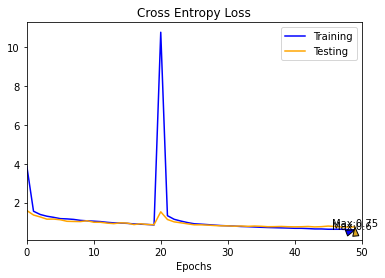

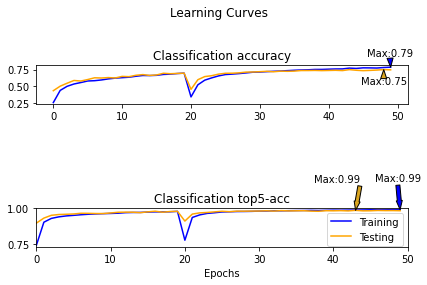

In [28]:
curves(tested_history)

In [29]:
# Set manually the values of your loaded model (change this parameters according to your previous selection)
embedding_dim = 386
num_blocks = 12

Random Example

In [30]:
#Run separtely once to avoid randomness
num_example = 39
example_prepro = Preprocessing(num_example)

In [31]:
#Select a MixerBlock and visualize the activation
n_MixerLayer = 2

bt_result = Mixer_Activations(tested_model,example_prepro)
visualize_out(bt_result,n_MixerLayer,num_example)

ValueError: in user code:

    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_80" is incompatible with the layer: expected shape=(None, 49, 384), found shape=(None, 49, 386)


In [ ]:
## Heatmap of activations of the random sample
sigma = 1
type = 'kernel'
######################################################
bt_heatmap_CKA_ran = Heatmap(bt_result,type,sigma)
visualize_Heatmap(bt_heatmap_CKA_ran,type,False)

Batch

In [ ]:
#Run separtely once to avoid randomness 
batch_prepro = Batch_Preprocessing(batch_size)

In [ ]:
# Heatmap of Average of layer's activation
sigma = 1
type = 'kernel'
######################################################
A1_ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
A1_global_heatmap = Heatmap(A1_ave_mixer_activations,type,sigma)
visualize_Heatmap(A1_global_heatmap,type,False)

## 1B

In [ ]:
#Change this parameters
accuracy_evolution_tested = tested_acc_evolution[0] # the index represents the position of num_blocks
name = '_8L' # num_block[0] = 8 (layers)
######################################################
block = len(accuracy_evolution_tested)
x = list(range(1,block+1))
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x,accuracy_evolution_tested,marker='o')
ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy')
plt.locator_params(axis='x', nbins=block)
plt.title('Evolution of Accuracy')
plt.tight_layout()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('Results_Article/1B/EvolutionAcc_' + name +'.png') 
plt.show()
